In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib.colors import LogNorm, Normalize
import pylab
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import pickle
import xml.etree.ElementTree as ET

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 24})

In [3]:
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

In [4]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# constants

In [5]:
Emin = 1.6 # min energy
conv = 1e-27*0.389379304 # [GeV*cm^2]<-- conversion factor for xsec[GeV^-2] -> xsec[cm^2]
ice_dens = 1.#  0.93 # g/cm^3

global_path_p = '../../../files/tot_xsec/xsec_quick_start/protons/'
global_path_n = '../../../files/tot_xsec/xsec_quick_start/neutrons/'
files_save_path = '../../../files/tot_xsec/'

# read .npy files - quick start

In [6]:
g_i = np.load(global_path_n+'genie_ind_n.npy')[0]
h_i = np.load(global_path_n+'hedis_ind_n.npy')[0]

g_v = np.load(global_path_n+'genie_totxsec_vars_n.npy')[0]
h_v = np.load(global_path_n+'hedis_totxsec_vars_n.npy')[0]
n_v = np.load(global_path_n+'nugen_csms_totxsec_vars_n.npy')[0]

#~~~~

ind_NuMu_CC_n = g_i['NuMu_CC_O_n']
ind_NuMu_NC_n = g_i['NuMu_NC_O_n']
ind_NuMu_Bar_CC_n = g_i['NuMu_Bar_CC_O_n']
ind_NuMu_Bar_NC_n = g_i['NuMu_Bar_NC_O_n']

ind_hedis_NuMu_CC_n = h_i['NuMu_CC_n']
ind_hedis_NuMu_NC_n = h_i['NuMu_NC_n']
ind_hedis_NuMu_Bar_CC_n = h_i['NuMu_Bar_CC_n']
ind_hedis_NuMu_Bar_NC_n = h_i['NuMu_Bar_NC_n']


lgE_genie_n = g_v['lgE']
xsec_E_genie_n = g_v['xsec_per_E']

lgE_hedis_n = h_v['lgE']
xsec_E_hedis_n = h_v['xsec_per_E']

lgE_nugen_n = n_v['lgE']
xsec_E_nugen_n = n_v['xsec_per_E']

In [7]:
g_i = np.load(global_path_p+'genie_ind.npy')[0]
h_i = np.load(global_path_p+'hedis_ind.npy')[0]

g_v = np.load(global_path_p+'genie_totxsec_vars.npy')[0]
h_v = np.load(global_path_p+'hedis_totxsec_vars.npy')[0]
n_v = np.load(global_path_p+'nugen_csms_totxsec_vars.npy')[0]

#~~~~

ind_NuMu_CC_p = g_i['NuMu_CC_O_p']
ind_NuMu_NC_p = g_i['NuMu_NC_O_p']
ind_NuMu_Bar_CC_p = g_i['NuMu_Bar_CC_O_p']
ind_NuMu_Bar_NC_p = g_i['NuMu_Bar_NC_O_p']

ind_hedis_NuMu_CC_p = h_i['NuMu_CC_p']
ind_hedis_NuMu_NC_p = h_i['NuMu_NC_p']
ind_hedis_NuMu_Bar_CC_p = h_i['NuMu_Bar_CC_p']
ind_hedis_NuMu_Bar_NC_p = h_i['NuMu_Bar_NC_p']


lgE_genie_p = g_v['lgE']
xsec_E_genie_p = g_v['xsec_per_E']

lgE_hedis_p = h_v['lgE']
xsec_E_hedis_p = h_v['xsec_per_E']

lgE_nugen_p = n_v['lgE']
xsec_E_nugen_p = n_v['xsec_per_E']

# read xsec from .dat files

In [8]:
def read_xsec_from_dat_file(pth, name, ftype = '.dat'):
    
    filename = pth + name + ftype
    print 'reading file: ', filename
    
    datContent = [i.strip().split() 
                  for i in open(filename).readlines()]
    
    dat_nedges = int(datContent[0][0])
    dat_st_bins = int(datContent[0][2])
    dat_end_bins = int(datContent[0][3])

    dat_lgE_bins = np.linspace(dat_st_bins, dat_end_bins, dat_nedges)
    dat_lgE_bin_centers = dat_lgE_bins[:-1]# + (dat_lgE_bins[1] - dat_lgE_bins[0])/2.

    dat_xsec = [float(datContent[i][0]) for i in range(1, len(datContent)-1)]
    dat_xsec = np.array(dat_xsec) * 1.0e-27

    return dat_lgE_bin_centers, dat_xsec

def read_list_xsec_dat_files(pth, names, ftype='.dat'):
    
    d = {}
    for i in range(len(names)):
        name = names[i]
        
        dat_lgE_bin_centers, dat_xsec = read_xsec_from_dat_file(pth, name, ftype=ftype)
        dat_xsec_per_E = dat_xsec/10.**(dat_lgE_bin_centers)
        
        d[name] = {'lgE':dat_lgE_bin_centers, 'xsec':dat_xsec, 'xsec_per_E':dat_xsec_per_E}
        
    return d

In [9]:
pth_csms_dat = '/home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/'
names_csms_dat = ['total_nu_CC_iso_NLO_HERAPDF1.5NLO_EIG', 'total_nu_NC_iso_NLO_HERAPDF1.5NLO_EIG', 
                  'total_nubar_NC_iso_NLO_HERAPDF1.5NLO_EIG', 'total_nubar_CC_iso_NLO_HERAPDF1.5NLO_EIG']

xsec_csms = read_list_xsec_dat_files(pth=pth_csms_dat, names=names_csms_dat)

reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nu_CC_iso_NLO_HERAPDF1.5NLO_EIG.dat
reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nu_NC_iso_NLO_HERAPDF1.5NLO_EIG.dat
reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nubar_NC_iso_NLO_HERAPDF1.5NLO_EIG.dat
reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nubar_CC_iso_NLO_HERAPDF1.5NLO_EIG.dat


In [10]:
pth_csms_dat = '/home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/'
names_csms_dat = ['total_nu_CC_p_NLO_HERAPDF1.5NLO_EIG', 'total_nu_NC_p_NLO_HERAPDF1.5NLO_EIG', 
                  'total_nubar_NC_p_NLO_HERAPDF1.5NLO_EIG', 'total_nubar_CC_p_NLO_HERAPDF1.5NLO_EIG']

xsec_csms_p = read_list_xsec_dat_files(pth=pth_csms_dat, names=names_csms_dat)

reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nu_CC_p_NLO_HERAPDF1.5NLO_EIG.dat
reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nu_NC_p_NLO_HERAPDF1.5NLO_EIG.dat
reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nubar_NC_p_NLO_HERAPDF1.5NLO_EIG.dat
reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nubar_CC_p_NLO_HERAPDF1.5NLO_EIG.dat


In [11]:
pth_csms_dat = '/home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/'
names_csms_dat = ['total_nu_CC_n_NLO_HERAPDF1.5NLO_EIG', 'total_nu_NC_n_NLO_HERAPDF1.5NLO_EIG', 
                  'total_nubar_NC_n_NLO_HERAPDF1.5NLO_EIG', 'total_nubar_CC_n_NLO_HERAPDF1.5NLO_EIG']

xsec_csms_n = read_list_xsec_dat_files(pth=pth_csms_dat, names=names_csms_dat)

reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nu_CC_n_NLO_HERAPDF1.5NLO_EIG.dat
reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nu_NC_n_NLO_HERAPDF1.5NLO_EIG.dat
reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nubar_NC_n_NLO_HERAPDF1.5NLO_EIG.dat
reading file:  /home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/total_nubar_CC_n_NLO_HERAPDF1.5NLO_EIG.dat


# NuMu Bar CC xsec from Gazizov at al.

In [12]:
d_x,d_y = np.load('/home/maria/IceCube/crosssections/Genie_vs_NuGen/total_xsec/extrapolations_to_low_en/iso_comp_to_data/NuMu_Bar_Gazizov.npy')

In [13]:
gaz_lgE = np.log10(d_x['DIS_fit'])
gaz_xsec = np.array(d_y['DIS_fit'])

gaz_lgE_unc_top = np.log10(d_x['DIS_unc_top'])
gaz_xsec_unc_top = np.array(d_y['DIS_unc_top'])
gaz_lgE_unc_bot = np.log10(d_x['DIS_unc_bot'])
gaz_xsec_unc_bot = np.array(d_y['DIS_unc_bot'])

In [14]:
gaz_sum_lgE = np.log10(d_x['QES_RES_DIS_fit'])
gaz_sum_xsec = np.array(d_y['QES_RES_DIS_fit'])

In [15]:
gaz_genie_lgE = np.log10(d_x['genie'])
gaz_genie_xsec = np.array(d_y['genie'])

# NuMu CC xsec from Gazizov at al.

In [16]:
d_x,d_y = np.load('/home/maria/IceCube/crosssections/Genie_vs_NuGen/total_xsec/extrapolations_to_low_en/iso_comp_to_data/NuMu_Gazizov.npy')

In [17]:
gaz_lgE_numu = np.log10(d_x['DIS_fit'])
gaz_xsec_numu = np.array(d_y['DIS_fit'])

gaz_lgE_unc_top_numu = np.log10(d_x['DIS_unc_top'])
gaz_xsec_unc_top_numu = np.array(d_y['DIS_unc_top'])
gaz_lgE_unc_bot_numu = np.log10(d_x['DIS_unc_bot'])
gaz_xsec_unc_bot_numu = np.array(d_y['DIS_unc_bot'])

In [18]:
gaz_sum_lgE_numu = np.log10(d_x['QES_RES_DIS_fit'])
gaz_sum_xsec_numu = np.array(d_y['QES_RES_DIS_fit'])

In [19]:
gaz_data_lgE_numu = np.log10(d_x['data'])
gaz_data_xsec_numu = np.array(d_y['data'])

# Nu and NuBar CC from CSMS paper

In [20]:
d_csms_paper = np.load('../total_xsec_cc_from_csms_paper.npy')[0]

# NuMu CC xsec from eV 2 EeV

In [21]:
d_x,d_y = np.load('/home/maria/IceCube/crosssections/Genie_vs_NuGen/total_xsec/extrapolations_to_low_en/iso_comp_to_data/NuMu_eV2EeV.npy')

In [22]:
ev_lgE_numu = np.log10(d_x['dis'])
ev_xsec_numu = np.array(d_y['dis'])

ev_sum_lgE_numu = np.log10(d_x['total'])
ev_sum_xsec_numu = np.array(d_y['total'])

# NuMu Bar CC xsec from eV 2 EeV

In [23]:
d_x,d_y = np.load('/home/maria/IceCube/crosssections/Genie_vs_NuGen/total_xsec/extrapolations_to_low_en/iso_comp_to_data/NuMu_Bar_eV2EeV.npy')

In [24]:
ev_lgE_numu_bar = np.log10(d_x['dis'])
ev_xsec_numu_bar = np.array(d_y['dis'])

ev_sum_lgE_numu_bar = np.log10(d_x['total'])
ev_sum_xsec_numu_bar = np.array(d_y['total'])

# ------------------------
# PLOTS corrected by cuts from phase space
# ------------------------

In [25]:
asp_r = 1./12.*6.

left, width = 0.26, 0.84
bottom, height = 0.1, 0.75
bottom_h = bottom + height + 0.02
left_h = left + width + 0.02

rect1 = [left*asp_r, bottom+0.3, width, height-0.2]
rect2 = [left*asp_r, bottom, width, 0.28]

In [26]:
def plot_xsec_corr(il_genie_p=ind_NuMu_CC_p, il_genie_n=ind_NuMu_CC_n,
                  key_csms = 'total_nu_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                  title = 'NuMu CC', save_name = 'NuMu_CC',
                  y_r=[0.,1.e-38],
                  linfit_max_lgE=4.):
    
    fig = plt.figure()
    fig.set_figheight(12)
    fig.set_figwidth(12)
    ax = plt.axes(rect1)

    ax.set_xlim(1.,4.)
    ax.set_ylim(y_r)
    ax.set_title(title + ': isoscalar')
#     ax.set_ylabel('total xsec/E, cm^2/GeV')
    ax.set_ylabel(r'$\mathrm{\sigma_{tot}/E, cm^2/GeV}$')
    plt.xticks(visible=False)

    comm_x = np.linspace(1.,4.0,100)

    # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    
    ax.plot(xsec_csms[key_csms]['lgE'], 
            xsec_csms[key_csms]['xsec_per_E'],
            lw=3, linestyle=':', color='b', label = 'CSMS (NUGEN)')
    
    x = xsec_csms[key_csms]['lgE']
    y = xsec_csms[key_csms]['xsec_per_E']
    fitpar = np.polyfit(x, y, 9)
    fit_dat_csms = np.polyval(fitpar, comm_x)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    fit_arr_p = []
    for i in range(len(il_genie_p)):

        i_g2 = il_genie_p[i]
        if len(i_g2) > 0:
            x = lgE_genie_p[i_g2]
            y = xsec_E_genie_p[i_g2]#/8.
            fitpar = np.polyfit(x, y, 8)
            fit = np.polyval(fitpar, comm_x)
            fit_arr_p.append(fit)
            
    fit_arr_p = np.array(fit_arr_p)
    sum_fit_p = np.sum(fit_arr_p, axis=0)
    
    fit_arr_n = []
    for i in range(len(il_genie_n)):

        i_g2 = il_genie_n[i]
        if len(i_g2) > 0:
            x = lgE_genie_n[i_g2]
            y = xsec_E_genie_n[i_g2]#/8.
            fitpar = np.polyfit(x, y, 8)
            fit = np.polyval(fitpar, comm_x)
            fit_arr_n.append(fit)

    fit_arr_n = np.array(fit_arr_n)
    sum_fit_n = np.sum(fit_arr_n, axis=0)
    
    sum_fit_iso = (sum_fit_p+sum_fit_n)/2.
    ax.plot(comm_x, sum_fit_iso, linestyle='-', c='red', lw=3, label=r'GENIE, w/o cuts')
    
    fit_xyQ2_p = np.polyval(cut_xyQ2_p, comm_x)
    fit_xyQ2_n = np.polyval(cut_xyQ2_n, comm_x)
    
    sum_fit_iso_cuts = (sum_fit_p*fit_xyQ2_p+sum_fit_n*fit_xyQ2_n)/2.
    
    ax.plot(comm_x, sum_fit_iso_cuts, '--', c='g', lw=3, 
            label=r'GENIE, w/ cuts in {$\mathrm{x,y,Q^2}$}')
    
    f = np.polyfit(comm_x, fit_dat_csms/sum_fit_iso_cuts, 7)
    f_v = np.polyval(f, comm_x)
    
    ax.plot(comm_x, sum_fit_iso*f_v, linestyle='-', c='cyan', lw=3, 
            label=r'GENIE, w/o cuts, corrected')
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax.axvline(1.68, lw=1, linestyle='-', color='k', label='50 GeV')
    ax.grid(color='grey', linestyle='--', linewidth=0.4, alpha=0.5)
    plt.legend(fontsize=15, ncol=2)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    ax2 = plt.axes(rect2)
    ax2.set_xlim(1.,4.)
    ax2.set_ylim(0.75, 1.25)
    ax2.set_yticks([0.8, 0.9, 1.0, 1.1, 1.2])
    ax2.set_xlabel(r'$\mathrm{log10(E), GeV}$')
    ax2.set_ylabel(r'$\mathrm{\sigma_{CSMS} / \sigma_*}$')
    
    ratio_w_cuts = fit_dat_csms/sum_fit_iso_cuts
    
    ax2.plot(comm_x, fit_dat_csms/sum_fit_iso, linestyle='-', c='red', lw=3)
    ax2.plot(comm_x, ratio_w_cuts, '--', c='green', lw=3, 
             label='cut on x>x_min + y>y_min + Q2>Q2_min')    
        
    #~~~~~~~~~~~~~~~
    comm_x_20 = np.linspace(1.,4.0,1000)

    f = np.polyfit(comm_x, ratio_w_cuts, 7)
    f_v = np.polyval(f, comm_x_20)
    #~~~~~~~~~~~~~~~
    i = 22 
    print i, comm_x[i]
    freeze = (fit_dat_csms/sum_fit_iso_cuts)[i]
    print freeze
    #~~~~~~~~~~~~~~~
    ind_linfit_low_en_cut = np.transpose(np.argwhere(comm_x>comm_x[i]))[0]
    ind_linfit0 = np.transpose(np.argwhere(comm_x[ind_linfit_low_en_cut]<linfit_max_lgE))[0]
    ind_linfit = ind_linfit_low_en_cut[ind_linfit0]
    linfit = np.polyfit(comm_x[ind_linfit], ratio_w_cuts[ind_linfit], 1)
    linfit_val = np.polyval(linfit, comm_x)
    ax2.plot(comm_x, linfit_val, c='y')
    linfit_corr = [linfit[0], linfit[1]-(np.polyval(linfit, comm_x[i]) - freeze)]
    linfit_val_corr = np.polyval(linfit_corr, comm_x)
    ax2.plot(comm_x, linfit_val_corr, c='orange')
    #~~~~~~~~~~~~~~~

    ax2.axvline(1.68, lw=1, linestyle='-', color='k')
    ax2.axhline(1.0, lw=3, linestyle=':', color='b')
    ax2.grid(color='grey', linestyle='--', linewidth=0.4, alpha=0.5)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    
#     save_name = title.replace(' ', '_')
#     save_path_latex = '/home/maria/IceCube/crosssections/fig_latex/total_xsec/low_en/'
#     plt.savefig(save_path_latex+save_name+'_iso_low_en'+'.png', dpi='figure')
#     plt.savefig(save_path_latex+save_name+'_iso_low_en'+'.pdf', dpi='figure')
    plt.show()
    
    return f, freeze, linfit_corr

In [27]:
save_pth = '/home/maria/IceCube/crosssections/fig_latex/total_xsec/pres_update_oct23/validation/'

In [28]:
pth_cuts = '/home/maria/IceCube/crosssections/Genie_vs_NuGen/param_sp_check/'

# cut Q2>1.0

22 1.6666666666666667
1.0594018527081688


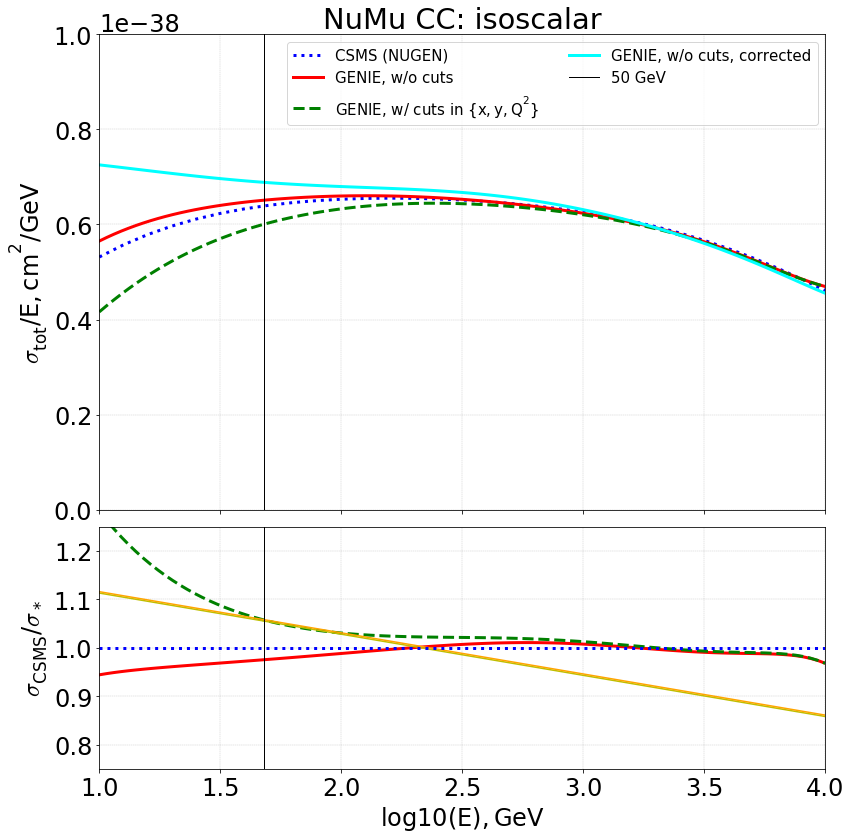

In [32]:
fitpar_dict_p = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_CC_p.npy')[0]

fitpar_dict_n = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_CC_n.npy')[0]

cut_xyQ2_p = fitpar_dict_p['xyQ2']
cut_xyQ2_n = fitpar_dict_n['xyQ2']

f, c, l = plot_xsec_corr(il_genie_p=ind_NuMu_CC_p, il_genie_n=ind_NuMu_CC_n,
                      key_csms = 'total_nu_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                      title = 'NuMu CC', save_name = 'NuMu_CC',
                      linfit_max_lgE = 2.)

np.save('interp/1GeV_interp_NuMu_CC_iso.npy', 
        [{'poly_coef':f, 'lgE_min':1.68, 'lgEmax':4., 'c':c, 'linear':l}])

22 1.6666666666666667
1.2284160691275503


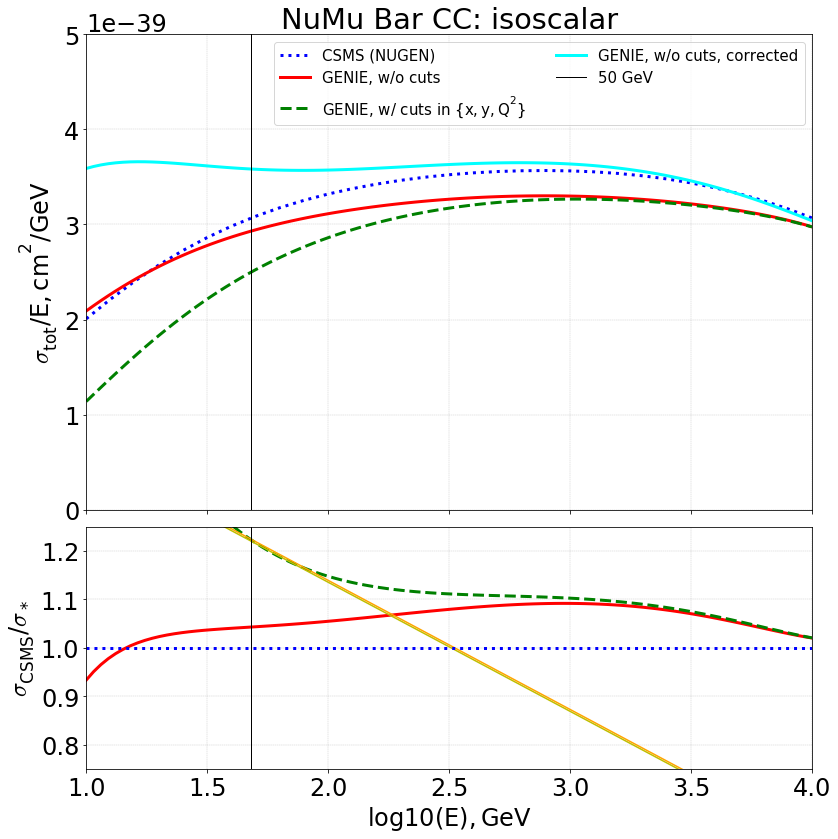

In [31]:
fitpar_dict_p = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_CC_p.npy')[0]

fitpar_dict_n = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_CC_n.npy')[0]

cut_xyQ2_p = fitpar_dict_p['xyQ2']
cut_xyQ2_n = fitpar_dict_n['xyQ2']

f, c, l = plot_xsec_corr(il_genie_p=ind_NuMu_Bar_CC_p, il_genie_n=ind_NuMu_Bar_CC_n,
                      key_csms = 'total_nubar_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                      title = 'NuMu Bar CC', y_r=[0.,0.5e-38],
                      linfit_max_lgE = 1.9)

np.save('interp/1GeV_interp_NuMu_Bar_CC_iso.npy', 
        [{'poly_coef':f, 'lgE_min':1.68, 'lgEmax':4., 'c':c, 'linear':l}])

22 1.6666666666666667
0.9752585062310415


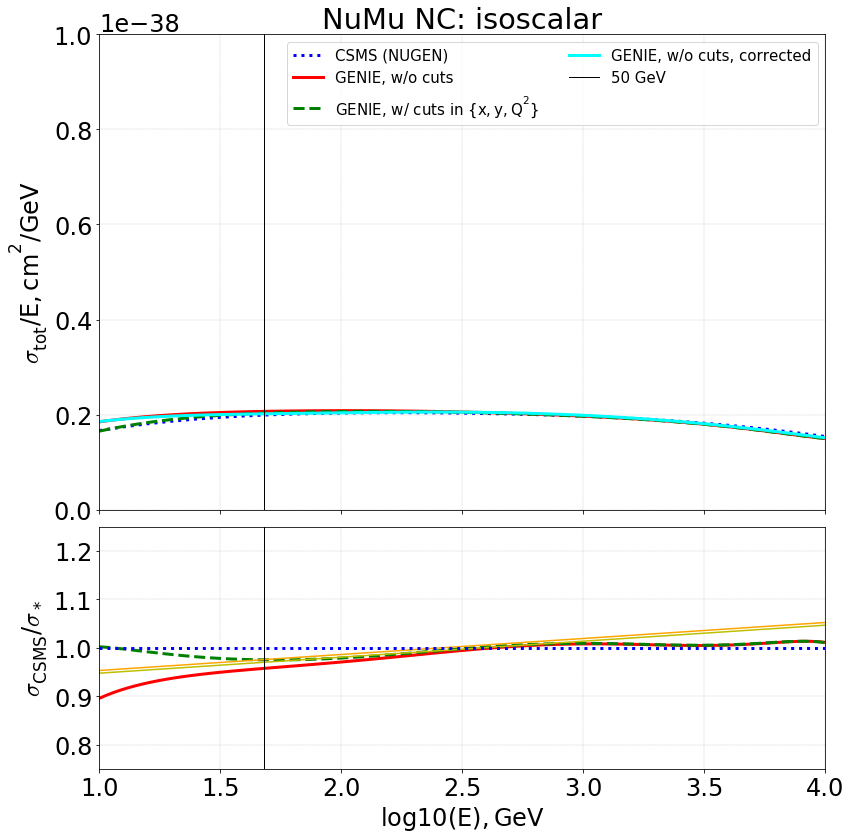

In [33]:
fitpar_dict_p = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_NC_p.npy')[0]

fitpar_dict_n = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_NC_n.npy')[0]

cut_xyQ2_p = fitpar_dict_p['xyQ2']
cut_xyQ2_n = fitpar_dict_n['xyQ2']

f, c, l = plot_xsec_corr(il_genie_p=ind_NuMu_NC_p, il_genie_n=ind_NuMu_NC_n,
                      key_csms = 'total_nu_NC_iso_NLO_HERAPDF1.5NLO_EIG',
                      title = 'NuMu NC',
                      linfit_max_lgE = 2.7)

np.save('interp/1GeV_interp_NuMu_NC_iso.npy', 
        [{'poly_coef':f, 'lgE_min':1.68, 'lgEmax':4., 'c':c, 'linear':l}])

22 1.6666666666666667
1.0482225145944062


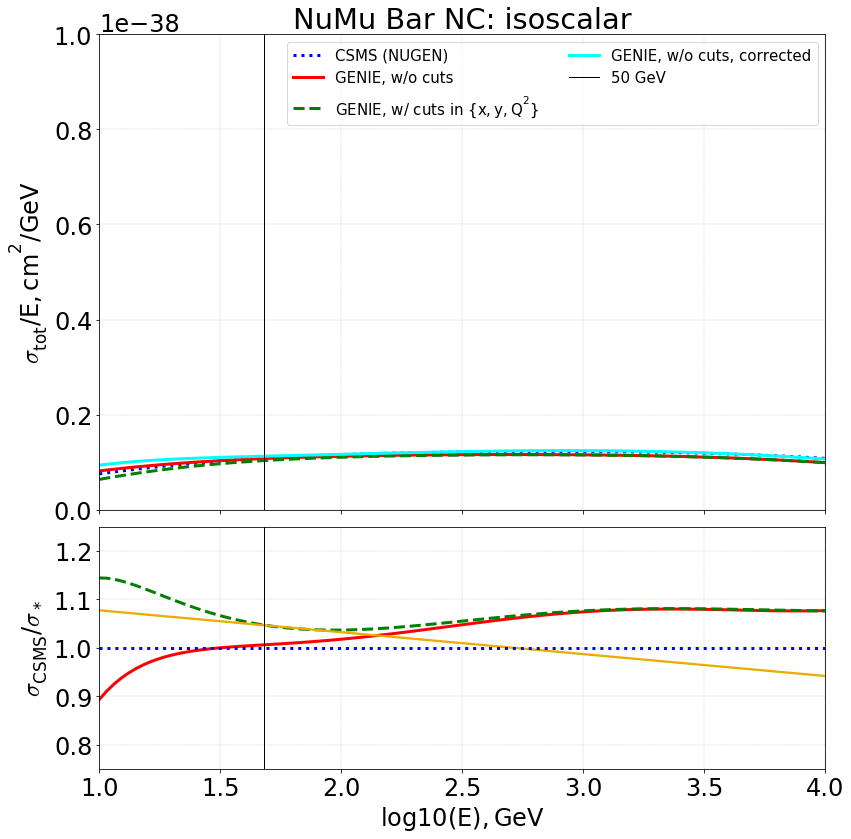

In [34]:
fitpar_dict_p = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_NC_p.npy')[0]

fitpar_dict_n = np.load(pth_cuts+
    '1GeV_low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_NC_n.npy')[0]

cut_xyQ2_p = fitpar_dict_p['xyQ2']
cut_xyQ2_n = fitpar_dict_n['xyQ2']

f, c, l = plot_xsec_corr(il_genie_p=ind_NuMu_Bar_NC_p, il_genie_n=ind_NuMu_Bar_NC_n,
                      key_csms = 'total_nubar_NC_iso_NLO_HERAPDF1.5NLO_EIG',
                      title = 'NuMu Bar NC',
                      linfit_max_lgE = 1.9)

np.save('interp/1GeV_interp_NuMu_Bar_NC_iso.npy', 
        [{'poly_coef':f, 'lgE_min':1.68, 'lgEmax':4., 'c':c, 'linear':l}])

# cut Q2>0.8

22 1.6666666666666667
1.0368147631910702


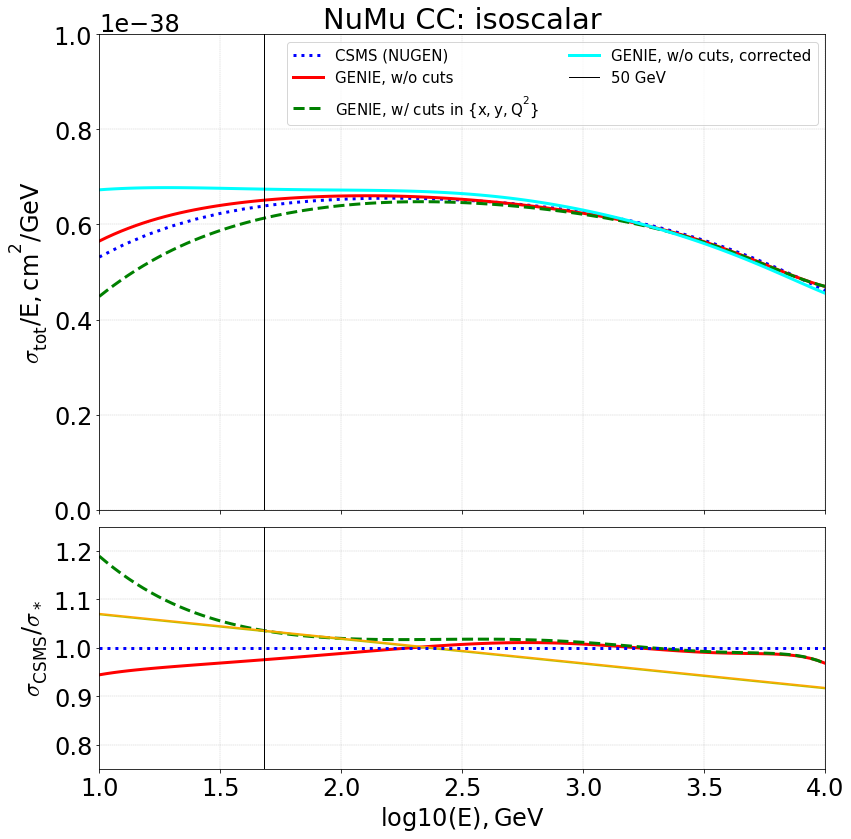

In [47]:
fitpar_dict_p = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_CC_p.npy')[0]

fitpar_dict_n = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_CC_n.npy')[0]

cut_xyQ2_p = fitpar_dict_p['xyQ2']
cut_xyQ2_n = fitpar_dict_n['xyQ2']

f, c, l = plot_xsec_corr(il_genie_p=ind_NuMu_CC_p, il_genie_n=ind_NuMu_CC_n,
                      key_csms = 'total_nu_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                      title = 'NuMu CC', save_name = 'NuMu_CC',
                      linfit_max_lgE = 2.)

np.save('interp/interp_NuMu_CC_iso.npy', 
        [{'poly_coef':f, 'lgE_min':1.68, 'lgEmax':4., 'c':c, 'linear':l}])

22 1.6666666666666667
1.178153660485833


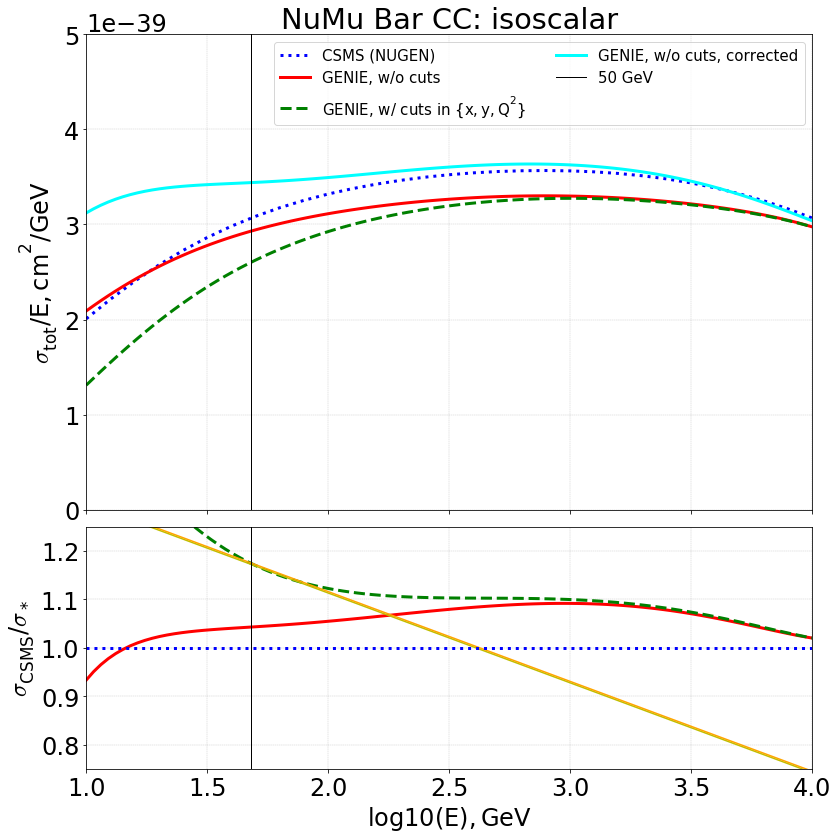

In [48]:
fitpar_dict_p = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_CC_p.npy')[0]

fitpar_dict_n = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_CC_n.npy')[0]

cut_xyQ2_p = fitpar_dict_p['xyQ2']
cut_xyQ2_n = fitpar_dict_n['xyQ2']

f, c, l = plot_xsec_corr(il_genie_p=ind_NuMu_Bar_CC_p, il_genie_n=ind_NuMu_Bar_CC_n,
                      key_csms = 'total_nubar_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                      title = 'NuMu Bar CC', y_r=[0.,0.5e-38],
                      linfit_max_lgE = 1.9)

np.save('interp/interp_NuMu_Bar_CC_iso.npy', 
        [{'poly_coef':f, 'lgE_min':1.68, 'lgEmax':4., 'c':c, 'linear':l}])

22 1.6666666666666667
0.970630232961796


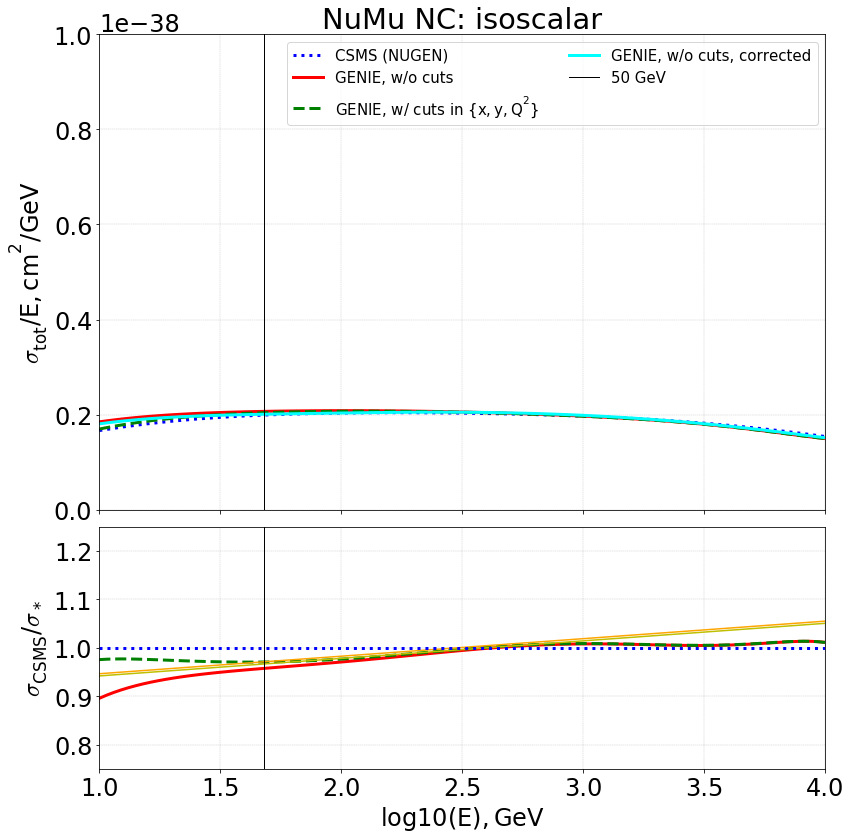

In [49]:
fitpar_dict_p = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_NC_p.npy')[0]

fitpar_dict_n = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_NC_n.npy')[0]

cut_xyQ2_p = fitpar_dict_p['xyQ2']
cut_xyQ2_n = fitpar_dict_n['xyQ2']

f, c, l = plot_xsec_corr(il_genie_p=ind_NuMu_NC_p, il_genie_n=ind_NuMu_NC_n,
                      key_csms = 'total_nu_NC_iso_NLO_HERAPDF1.5NLO_EIG',
                      title = 'NuMu NC',
                      linfit_max_lgE = 2.7)

np.save('interp/interp_NuMu_NC_iso.npy', 
        [{'poly_coef':f, 'lgE_min':1.68, 'lgEmax':4., 'c':c, 'linear':l}])

22 1.6666666666666667
1.0374398215019272


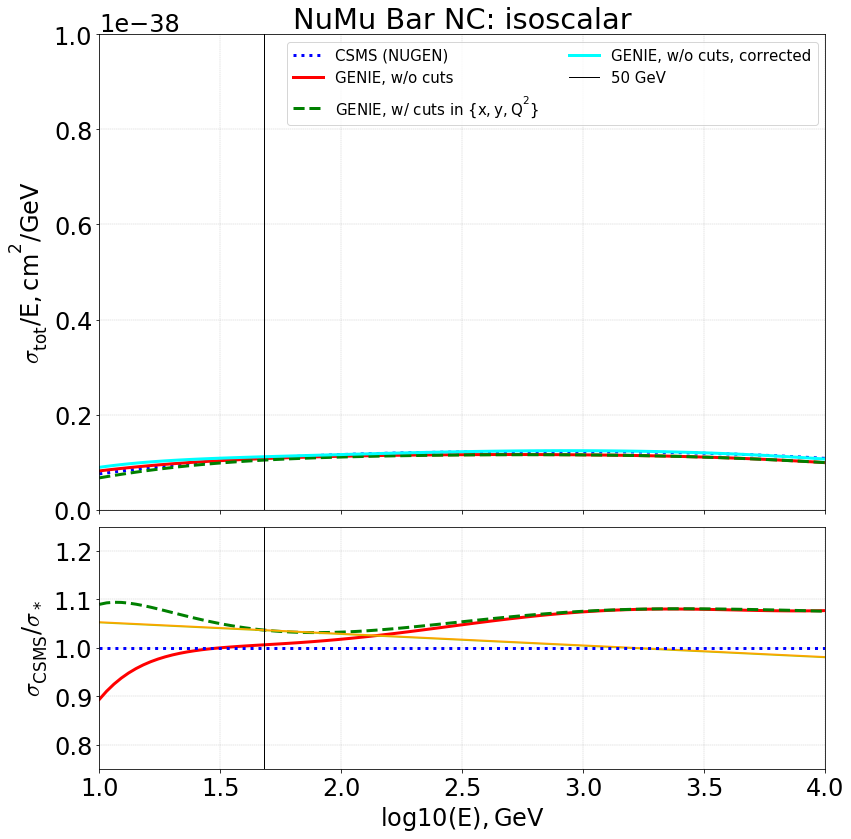

In [50]:
fitpar_dict_p = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_NC_p.npy')[0]

fitpar_dict_n = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_NC_n.npy')[0]

cut_xyQ2_p = fitpar_dict_p['xyQ2']
cut_xyQ2_n = fitpar_dict_n['xyQ2']

f, c, l = plot_xsec_corr(il_genie_p=ind_NuMu_Bar_NC_p, il_genie_n=ind_NuMu_Bar_NC_n,
                      key_csms = 'total_nubar_NC_iso_NLO_HERAPDF1.5NLO_EIG',
                      title = 'NuMu Bar NC',
                      linfit_max_lgE = 1.9)

np.save('interp/interp_NuMu_Bar_NC_iso.npy', 
        [{'poly_coef':f, 'lgE_min':1.68, 'lgEmax':4., 'c':c, 'linear':l}])

# old ratios!!!

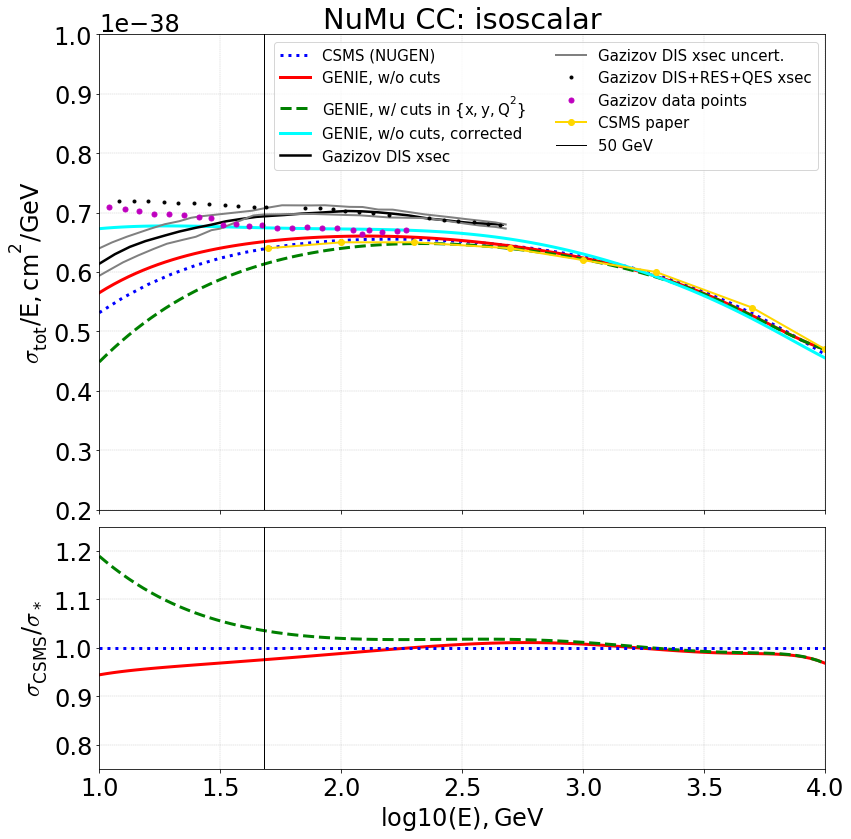

In [128]:
fitpar_dict_p = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_CC_p.npy')[0]

fitpar_dict_n = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_CC_n.npy')[0]

cut_xyQ2_p = fitpar_dict_p['xyQ2']
cut_xyQ2_n = fitpar_dict_n['xyQ2']

f = plot_xsec_corr(il_genie_p=ind_NuMu_CC_p, il_genie_n=ind_NuMu_CC_n,
                  key_csms = 'total_nu_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                  title = 'NuMu CC', save_name = 'NuMu_CC', y_r=[0.2e-38,1.e-38])

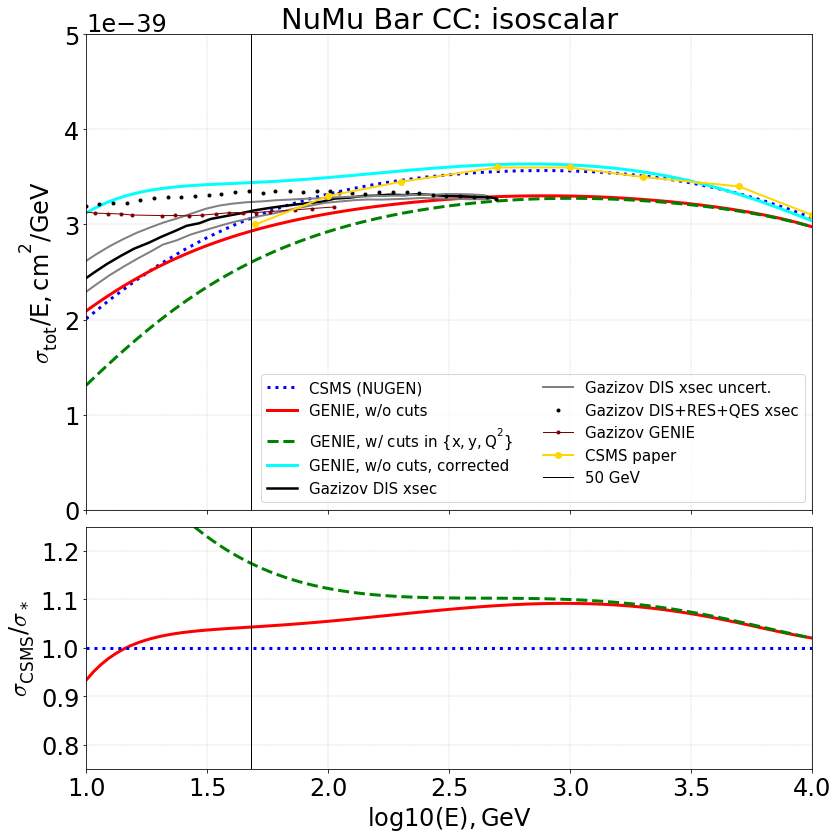

In [129]:
fitpar_dict_p = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_CC_p.npy')[0]

fitpar_dict_n = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_CC_n.npy')[0]

cut_xyQ2_p = fitpar_dict_p['xyQ2']
cut_xyQ2_n = fitpar_dict_n['xyQ2']

f = plot_xsec_corr(il_genie_p=ind_NuMu_Bar_CC_p, il_genie_n=ind_NuMu_Bar_CC_n,
                  key_csms = 'total_nubar_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                  title = 'NuMu Bar CC', y_r=[0.,0.5e-38])

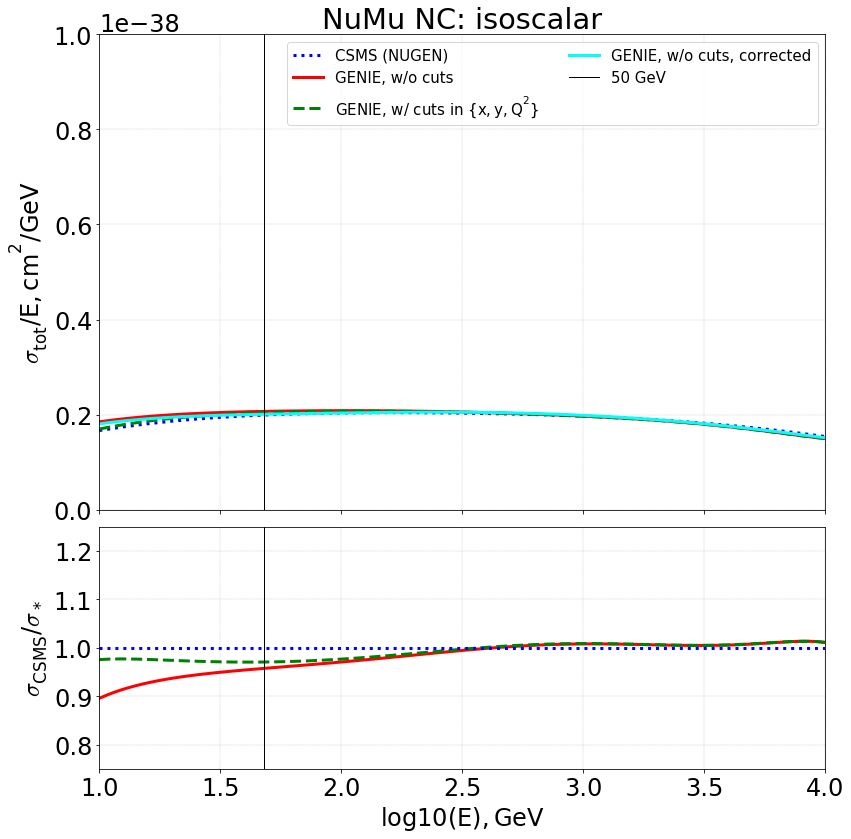

In [130]:
fitpar_dict_p = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_NC_p.npy')[0]

fitpar_dict_n = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_NC_n.npy')[0]

cut_xyQ2_p = fitpar_dict_p['xyQ2']
cut_xyQ2_n = fitpar_dict_n['xyQ2']

f = plot_xsec_corr(il_genie_p=ind_NuMu_NC_p, il_genie_n=ind_NuMu_NC_n,
                  key_csms = 'total_nu_NC_iso_NLO_HERAPDF1.5NLO_EIG',
                  title = 'NuMu NC')

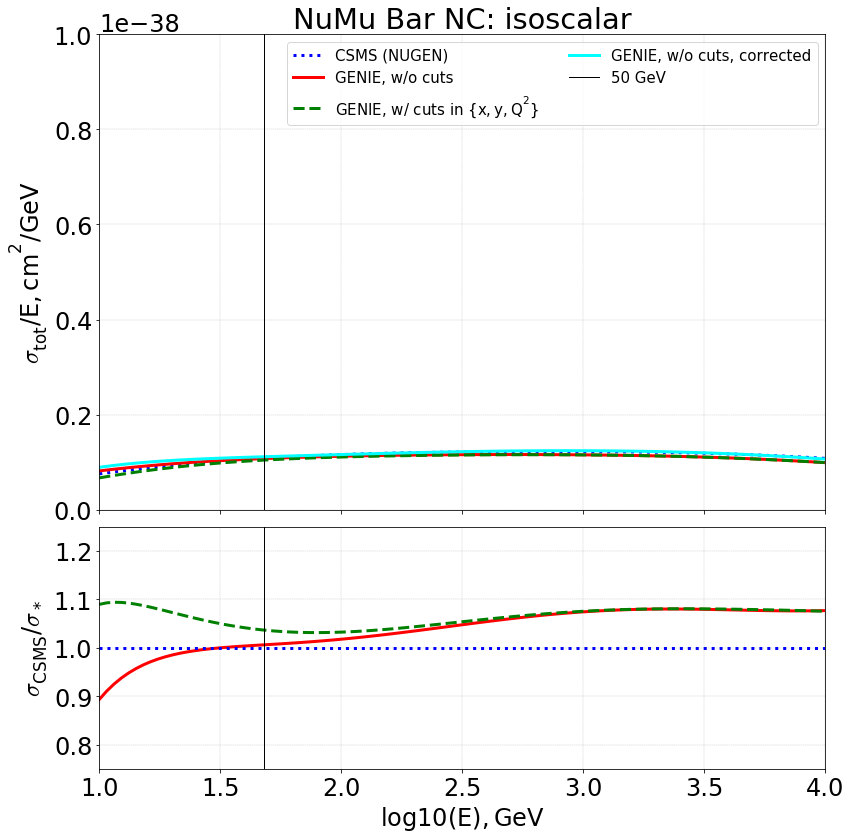

In [126]:
fitpar_dict_p = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_NC_p.npy')[0]

fitpar_dict_n = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_NC_n.npy')[0]

cut_xyQ2_p = fitpar_dict_p['xyQ2']
cut_xyQ2_n = fitpar_dict_n['xyQ2']

f = plot_xsec_corr(il_genie_p=ind_NuMu_Bar_NC_p, il_genie_n=ind_NuMu_Bar_NC_n,
                  key_csms = 'total_nubar_NC_iso_NLO_HERAPDF1.5NLO_EIG',
                  title = 'NuMu Bar NC')

In [66]:
print 'E[GeV]\t', 'sigma_nu[1e-38 cm^2]\t', 'sigma_nu_bar[1e-38 cm^2]'

i = 0
while d_csms_paper['E'][i] < 50000.:
    
    print int(d_csms_paper['E'][i]), '\t\t', d_csms_paper['sig_nu_cc'][i], '\t\t', d_csms_paper['sig_nubar_cc'][i]
    
    i += 1

E[GeV]	sigma_nu[1e-38 cm^2]	sigma_nu_bar[1e-38 cm^2]
50 		32.0 		15.0
100 		65.0 		33.0
200 		130.0 		69.0
500 		320.0 		180.0
1000 		620.0 		360.0
2000 		1200.0 		700.0
5000 		2700.0 		1700.0
10000 		4700.0 		3100.0
20000 		7700.0 		5500.0


In [67]:
print 'E[GeV]\t', 'sigma_nu/E[1e-38 cm^2/GeV]\t', 'sigma_nu_bar/E[1e-38 cm^2/GeV]'

i = 0
while d_csms_paper['E'][i] < 50000.:
    
    print int(d_csms_paper['E'][i]), '\t\t', d_csms_paper['sig_nu_cc'][i]/d_csms_paper['E'][i], \
    '\t\t', d_csms_paper['sig_nubar_cc'][i]/d_csms_paper['E'][i]
    
    i += 1

E[GeV]	sigma_nu/E[1e-38 cm^2/GeV]	sigma_nu_bar/E[1e-38 cm^2/GeV]
50 		0.64 		0.3
100 		0.65 		0.33
200 		0.65 		0.345
500 		0.64 		0.36
1000 		0.62 		0.36
2000 		0.6 		0.35
5000 		0.54 		0.34
10000 		0.47 		0.31
20000 		0.385 		0.275


# NuMu NC

In [17]:
def plot_xsec_corr_numu_nc(il_genie_p=ind_NuMu_CC,
                          il_hedis_p=ind_hedis_NuMu_CC, 
                          key_csms = 'total_nu_CC_n_NLO_HERAPDF1.5NLO_EIG',
                          title = 'NuMu CC', save_name = 'NuMu_CC',
                          y_r=[0.,1.e-38],
                          a = 0., p = 0.):
    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(10)
    ax = plt.axes(rect1)

    ax.set_xlim(1.,4.)
    ax.set_ylim(y_r)
    ax.set_title(title + ': neutrons')
#     ax.set_ylabel('total xsec/E, cm^2/GeV')
    ax.set_ylabel(r'$\mathrm{\sigma_{tot}/E, cm^2/GeV}$')
    plt.xticks(visible=False)

    comm_x = np.linspace(0.1,4.0,100)
    hedis_comm_x = np.linspace(2.,4.0,100)

    # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    fit_arr_p = []
    fit_arr_p_4hedis = []
    for i in range(len(il_genie_p)):

        i_g2 = il_genie_p[i]
        if len(i_g2) > 0:
            x = lgE_genie[i_g2]
            y = xsec_E_genie[i_g2]#/8.
            fitpar = np.polyfit(x, y, 8)
            fit = np.polyval(fitpar, comm_x)
            fit_arr_p.append(fit)
            
            fit_4hedis = np.polyval(fitpar, hedis_comm_x)
            fit_arr_p_4hedis.append(fit_4hedis)

    fit_arr_p = np.array(fit_arr_p)
    sum_fit_p = np.sum(fit_arr_p, axis=0)
    
    fit_arr_p_4hedis = np.array(fit_arr_p_4hedis)
    sum_fit_p_4hedis = np.sum(fit_arr_p_4hedis, axis=0)
    
    ax.plot(comm_x, sum_fit_p, linestyle='-', c='red', lw=3, label=r'GENIE, w/o cuts')
    
    fit_x = np.polyval(cut_x, comm_x)
    fit_xy = np.polyval(cut_xy, comm_x)
    fit_xyQ2 = np.polyval(cut_xyQ2, comm_x)
    
#     ax.plot(comm_x, sum_fit_p*fit_x, '-', label='cut on x>x_min')
#     ax.plot(comm_x, sum_fit_p*fit_xy, '-', label='cut on x>x_min + y>y_min')
    ax.plot(comm_x, sum_fit_p*fit_xyQ2, '--', c='g', lw=3, 
            label=r'GENIE, w/ cuts in {$\mathrm{x,y,Q^2}$}')
    
    
    corr = (comm_x**p)-a
    ax.plot(comm_x, sum_fit_p*fit_xyQ2*corr, '--', c='m', lw=3, 
        label=r'GENIE, w/ cuts, corrected')
    
    ax.plot(comm_x, sum_fit_p*corr, '--', c='cyan', lw=3, 
        label=r'GENIE, w/o cuts, corrected')
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    ax.plot(xsec_csms[key_csms]['lgE'], 
            xsec_csms[key_csms]['xsec_per_E'],
            lw=3, linestyle=':', color='b', label = 'CSMS (NUGEN)')
    
    x = xsec_csms[key_csms]['lgE']
    y = xsec_csms[key_csms]['xsec_per_E']
    fitpar = np.polyfit(x, y, 9)
    fit_dat_csms = np.polyval(fitpar, comm_x)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax.axvline(1.68, lw=1, linestyle='-', color='k', label='50 GeV')
    ax.grid(color='grey', linestyle='--', linewidth=0.4, alpha=0.5)
    plt.legend(fontsize=15, ncol=1)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    ax2 = plt.axes(rect2)
    ax2.set_xlim(1.,4.)
    ax2.set_ylim(0.75, 1.25)
    ax2.set_yticks([0.8, 0.9, 1.0, 1.1, 1.2])
    ax2.set_xlabel(r'$\mathrm{log10(E), GeV}$')
    ax2.set_ylabel(r'$\mathrm{\sigma_{CSMS} / \sigma_*}$')
    
#     ax2.plot(hedis_comm_x, hedis_sum_fit_p/sum_fit_p_4hedis, c='orange', 
#              lw=3, linestyle='--')
    ax2.plot(comm_x, fit_dat_csms/sum_fit_p, linestyle='-', c='red', lw=3)
#     ax2.plot(comm_x, fit_dat_csms/(sum_fit_p*fit_x), '-', 
#              label='cut on x>x_min')
#     ax2.plot(comm_x, fit_dat_csms/(sum_fit_p*fit_xy), '-', 
#              label='cut on x>x_min + y>y_min')
    ax2.plot(comm_x, fit_dat_csms/(sum_fit_p*fit_xyQ2), '--', c='green', lw=3, 
             label='cut on x>x_min + y>y_min + Q2>Q2_min')  
    
    ax2.plot(comm_x, corr, '--', c='limegreen', lw=3, 
             label='cut on x>x_min + y>y_min + Q2>Q2_min')  
        
    print 'a = ', a, '; p = ', p
        
    ax2.axhline(1.0, lw=3, linestyle=':', color='b')
    ax2.axvline(1.68, lw=1, linestyle='-', color='k')
    ax2.grid(color='grey', linestyle='--', linewidth=0.4, alpha=0.5)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    save_name = title.replace(' ', '_')
#     plt.savefig(global_save_path+save_name+'_n'+'.png', dpi='figure')
#     plt.savefig(global_save_path+save_name+'_n'+'.pdf', dpi='figure')
    plt.show()
    
    return 0

a =  0.15 ; p =  0.05


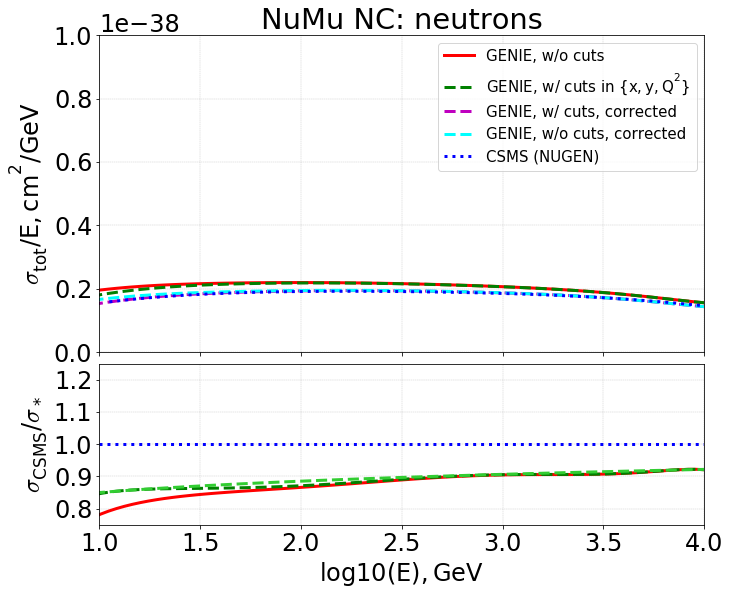

0

In [18]:
fitpar_dict = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_NC_n.npy')[0]

cut_x = fitpar_dict['x']
cut_xy = fitpar_dict['xy']
cut_xyQ2 = fitpar_dict['xyQ2']

plot_xsec_corr_numu_nc(il_genie_p=ind_NuMu_NC, 
                      il_hedis_p=ind_hedis_NuMu_NC,
                      key_csms = 'total_nu_NC_n_NLO_HERAPDF1.5NLO_EIG',
                      title = 'NuMu NC',
                      a=0.15, p=.05)

a =  0.15 ; p =  0.05


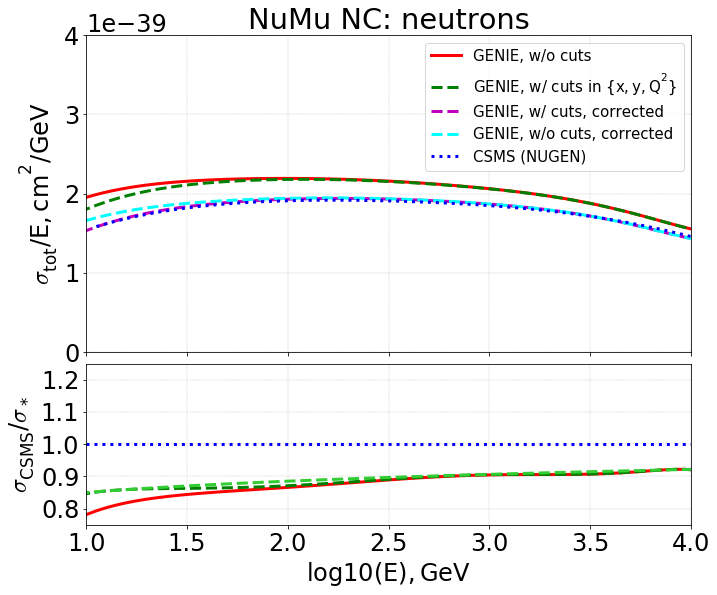

0

In [63]:
fitpar_dict = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_NC_n.npy')[0]

cut_x = fitpar_dict['x']
cut_xy = fitpar_dict['xy']
cut_xyQ2 = fitpar_dict['xyQ2']

plot_xsec_corr_numu_nc(il_genie_p=ind_NuMu_NC, 
                      il_hedis_p=ind_hedis_NuMu_NC,
                      key_csms = 'total_nu_NC_n_NLO_HERAPDF1.5NLO_EIG',
                      title = 'NuMu NC',
                      a=0.15, p=.05,
                      y_r = [0., 0.4e-38])

In [52]:
def plot_xsec_corr_numu_nc_extrap(il_genie_p=ind_NuMu_CC,
                          il_hedis_p=ind_hedis_NuMu_CC, 
                          key_csms = 'total_nu_CC_n_NLO_HERAPDF1.5NLO_EIG',
                          title = 'NuMu CC', save_name = 'NuMu_CC',
                          y_r=[0.,1.e-38],
                          a = 0., p = 0.):
    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(10)
    ax = plt.axes(rect1)

    ax.set_xlim(0.,4.)
    ax.set_ylim(y_r)
    ax.set_title(title + ': neutrons')
#     ax.set_ylabel('total xsec/E, cm^2/GeV')
    ax.set_ylabel(r'$\mathrm{\sigma_{tot}/E, cm^2/GeV}$')
    plt.xticks(visible=False)

    comm_x = np.linspace(1.,4.0,100)
    comm_x_extrap = np.linspace(0.0,1.0,100)   
    hedis_comm_x = np.linspace(2.,4.0,100)

    # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    fit_arr_p = []
    fit_arr_p_4hedis = []
    for i in range(len(il_genie_p)):

        i_g2 = il_genie_p[i]
        if len(i_g2) > 0:
            x = lgE_genie[i_g2]
            y = xsec_E_genie[i_g2]#/8.
            fitpar = np.polyfit(x, y, 8)
            fit = np.polyval(fitpar, comm_x)
            fit_arr_p.append(fit)

    fit_arr_p = np.array(fit_arr_p)
    sum_fit_p = np.sum(fit_arr_p, axis=0)
    
    ax.plot(comm_x, sum_fit_p, linestyle='-', c='red', lw=3, label=r'GENIE, w/o cuts')
    
    fit_x = np.polyval(cut_x, comm_x)
    fit_xy = np.polyval(cut_xy, comm_x)
    fit_xyQ2 = np.polyval(cut_xyQ2, comm_x)
    
#     ax.plot(comm_x, sum_fit_p*fit_x, '-', label='cut on x>x_min')
#     ax.plot(comm_x, sum_fit_p*fit_xy, '-', label='cut on x>x_min + y>y_min')
    ax.plot(comm_x, sum_fit_p*fit_xyQ2, '--', c='g', lw=3, 
            label=r'GENIE, w/ cuts in {$\mathrm{x,y,Q^2}$}')
    
    
    corr = (comm_x**p)-a
    ax.plot(comm_x, sum_fit_p*fit_xyQ2*corr, '--', c='m', lw=3, 
        label=r'GENIE, w/ cuts, corrected')
    
    ax.plot(comm_x, sum_fit_p*corr, '--', c='cyan', lw=3, 
        label=r'GENIE, w/o cuts, corrected')
    
    
    fit_arr_p = []
    fit_arr_p_4hedis = []
    for i in range(len(il_genie_p)):

        i_g2 = il_genie_p[i]
        if len(i_g2) > 0:
            x = lgE_genie[i_g2]
            y = xsec_E_genie[i_g2]#/8.
            fitpar = np.polyfit(x, y, 8)
            fit = np.polyval(fitpar, comm_x_extrap)
            fit_arr_p.append(fit)

    fit_arr_p_extrap = np.array(fit_arr_p)
    sum_fit_p_extrap = np.sum(fit_arr_p, axis=0)

    ax.plot(comm_x, sum_fit_p, linestyle='-', c='red', lw=3, label=r'GENIE, w/o cuts')
    
    fit_xyQ2_extrap = np.polyval(cut_xyQ2, comm_x_extrap)
    
#     ax.plot(comm_x, sum_fit_p*fit_x, '-', label='cut on x>x_min')
#     ax.plot(comm_x, sum_fit_p*fit_xy, '-', label='cut on x>x_min + y>y_min')
    ax.plot(comm_x_extrap, sum_fit_p_extrap*fit_xyQ2_extrap, '--', c='g', lw=3, 
            label=r'GENIE, w/ cuts in {$\mathrm{x,y,Q^2}$}')
    
    
    corr = (comm_x_extrap**p)-a
    ax.plot(comm_x_extrap, sum_fit_p_extrap*fit_xyQ2_extrap*corr, '--', c='pink', lw=3, 
        label=r'GENIE, w/ cuts, corrected')
    
    ax.plot(comm_x_extrap, sum_fit_p_extrap*corr, '--', c='c', lw=3, 
        label=r'GENIE, w/o cuts, corrected')
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    ax.plot(xsec_csms[key_csms]['lgE'], 
            xsec_csms[key_csms]['xsec_per_E'],
            lw=3, linestyle=':', color='b', label = 'CSMS (NUGEN)')
    
    x = xsec_csms[key_csms]['lgE']
    y = xsec_csms[key_csms]['xsec_per_E']
    fitpar = np.polyfit(x, y, 9)
    fit_dat_csms = np.polyval(fitpar, comm_x)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax.axvline(1.68, lw=1, linestyle='-', color='k', label='50 GeV')
    ax.grid(color='grey', linestyle='--', linewidth=0.4, alpha=0.5)
    plt.legend(fontsize=15, ncol=1)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    ax2 = plt.axes(rect2)
    ax2.set_xlim(0.,4.)
    ax2.set_ylim(0.75, 1.25)
    ax2.set_yticks([0.8, 0.9, 1.0, 1.1, 1.2])
    ax2.set_xlabel(r'$\mathrm{log10(E), GeV}$')
    ax2.set_ylabel(r'$\mathrm{\sigma_{CSMS} / \sigma_*}$')
    
#     ax2.plot(hedis_comm_x, hedis_sum_fit_p/sum_fit_p_4hedis, c='orange', 
#              lw=3, linestyle='--')
    ax2.plot(comm_x, fit_dat_csms/sum_fit_p, linestyle='-', c='red', lw=3)
#     ax2.plot(comm_x, fit_dat_csms/(sum_fit_p*fit_x), '-', 
#              label='cut on x>x_min')
#     ax2.plot(comm_x, fit_dat_csms/(sum_fit_p*fit_xy), '-', 
#              label='cut on x>x_min + y>y_min')
    ax2.plot(comm_x, fit_dat_csms/(sum_fit_p*fit_xyQ2), '--', c='green', lw=3, 
             label='cut on x>x_min + y>y_min + Q2>Q2_min')  
    
    ax2.plot(comm_x, corr, '--', c='limegreen', lw=3, 
             label='cut on x>x_min + y>y_min + Q2>Q2_min')  
        
    print 'a = ', a, '; p = ', p
        
    ax2.axhline(1.0, lw=3, linestyle=':', color='b')
    ax2.axvline(1.68, lw=1, linestyle='-', color='k')
    ax2.grid(color='grey', linestyle='--', linewidth=0.4, alpha=0.5)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~     
    
    constant = (fit_dat_csms/(sum_fit_p*fit_xyQ2))[0]
    print constant
    ax2.plot(comm_x_extrap, np.ones(len(comm_x_extrap))*constant)
    
    linear = np.polyfit(comm_x, fit_dat_csms/(sum_fit_p*fit_xyQ2), 1)
    print linear
    ax2.plot(comm_x_extrap, linear[0]*comm_x_extrap+linear[1])
    ax2.plot(comm_x, linear[0]*comm_x+linear[1], c='gold')
    

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    save_name = title.replace(' ', '_')
#     plt.savefig(global_save_path+save_name+'_n'+'.png', dpi='figure')
#     plt.savefig(global_save_path+save_name+'_n'+'.pdf', dpi='figure')
    plt.show()
    
    return constant, linear

a =  0.15 ; p =  0.05
0.8464485785285152
[0.02418538 0.8272242 ]


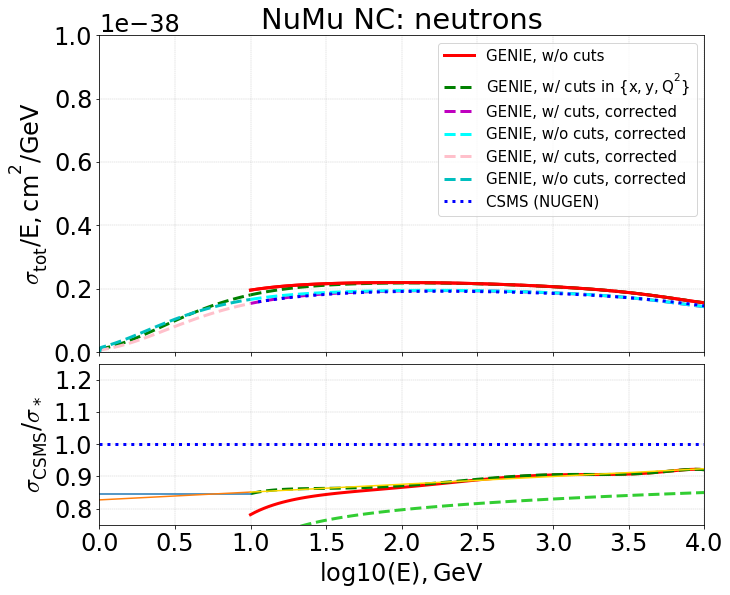

In [54]:
fitpar_dict = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_NC_n.npy')[0]

cut_x = fitpar_dict['x']
cut_xy = fitpar_dict['xy']
cut_xyQ2 = fitpar_dict['xyQ2']

c, l = plot_xsec_corr_numu_nc_extrap(il_genie_p=ind_NuMu_NC, 
                      il_hedis_p=ind_hedis_NuMu_NC,
                      key_csms = 'total_nu_NC_n_NLO_HERAPDF1.5NLO_EIG',
                      title = 'NuMu NC',
                      a=0.15, p=.05)

np.save('extrap/extrap_NuMu_NC_n.npy',[{'constant':c, 'linear':l, 'higher':None}])

# NuMu CC

In [55]:
def plot_xsec_corr_numu_cc_extrap(il_genie_p=ind_NuMu_CC,
                          il_hedis_p=ind_hedis_NuMu_CC, 
                          key_csms = 'total_nu_CC_n_NLO_HERAPDF1.5NLO_EIG',
                          title = 'NuMu CC', save_name = 'NuMu_CC',
                          y_r=[0.,1.e-38],
                          a = 0., p = 0.):
    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(10)
    ax = plt.axes(rect1)

    ax.set_xlim(0.,4.)
    ax.set_ylim(y_r)
    ax.set_title(title + ': neutrons')
#     ax.set_ylabel('total xsec/E, cm^2/GeV')
    ax.set_ylabel(r'$\mathrm{\sigma_{tot}/E, cm^2/GeV}$')
    plt.xticks(visible=False)

    comm_x = np.linspace(0.1,4.0,100)
    comm_x_extrap = np.linspace(0.0,1.0,100)  
    hedis_comm_x = np.linspace(2.,4.0,100)

    # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    fit_arr_p = []
    fit_arr_p_4hedis = []
    for i in range(len(il_genie_p)):

        i_g2 = il_genie_p[i]
        if len(i_g2) > 0:
            x = lgE_genie[i_g2]
            y = xsec_E_genie[i_g2]#/8.
            fitpar = np.polyfit(x, y, 8)
            fit = np.polyval(fitpar, comm_x)
            fit_arr_p.append(fit)
            
            fit_4hedis = np.polyval(fitpar, hedis_comm_x)
            fit_arr_p_4hedis.append(fit_4hedis)

    fit_arr_p = np.array(fit_arr_p)
    sum_fit_p = np.sum(fit_arr_p, axis=0)
    
    fit_arr_p_4hedis = np.array(fit_arr_p_4hedis)
    sum_fit_p_4hedis = np.sum(fit_arr_p_4hedis, axis=0)
    
    ax.plot(comm_x, sum_fit_p, linestyle='-', c='red', lw=3, label=r'GENIE, w/o cuts')
    
    fit_x = np.polyval(cut_x, comm_x)
    fit_xy = np.polyval(cut_xy, comm_x)
    fit_xyQ2 = np.polyval(cut_xyQ2, comm_x)
    
#     ax.plot(comm_x, sum_fit_p*fit_x, '-', label='cut on x>x_min')
#     ax.plot(comm_x, sum_fit_p*fit_xy, '-', label='cut on x>x_min + y>y_min')
    ax.plot(comm_x, sum_fit_p*fit_xyQ2, '--', c='g', lw=3, 
            label=r'GENIE, w/ cuts in {$\mathrm{x,y,Q^2}$}')
    
    
    corr = (comm_x**p)-a
    ax.plot(comm_x, sum_fit_p*fit_xyQ2*corr, '--', c='m', lw=3, 
        label=r'GENIE, w/ cuts, corrected')
    
    ax.plot(comm_x, sum_fit_p*corr, '--', c='cyan', lw=3, 
        label=r'GENIE, w/o cuts, corrected')
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    ax.plot(xsec_csms[key_csms]['lgE'], 
            xsec_csms[key_csms]['xsec_per_E'],
            lw=3, linestyle=':', color='b', label = 'CSMS (NUGEN)')
    
    x = xsec_csms[key_csms]['lgE']
    y = xsec_csms[key_csms]['xsec_per_E']
    fitpar = np.polyfit(x, y, 9)
    fit_dat_csms = np.polyval(fitpar, comm_x)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax.axvline(1.68, lw=1, linestyle='-', color='k', label='50 GeV')
    ax.grid(color='grey', linestyle='--', linewidth=0.4, alpha=0.5)
    plt.legend(fontsize=15, ncol=1)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    ax2 = plt.axes(rect2)
    ax2.set_xlim(0.,4.)
    ax2.set_ylim(0.75, 1.25)
    ax2.set_yticks([0.8, 0.9, 1.0, 1.1, 1.2])
    ax2.set_xlabel(r'$\mathrm{log10(E), GeV}$')
    ax2.set_ylabel(r'$\mathrm{\sigma_{CSMS} / \sigma_*}$')
    
#     ax2.plot(hedis_comm_x, hedis_sum_fit_p/sum_fit_p_4hedis, c='orange', 
#              lw=3, linestyle='--')
    ax2.plot(comm_x, fit_dat_csms/sum_fit_p, linestyle='-', c='red', lw=3)
#     ax2.plot(comm_x, fit_dat_csms/(sum_fit_p*fit_x), '-', 
#              label='cut on x>x_min')
#     ax2.plot(comm_x, fit_dat_csms/(sum_fit_p*fit_xy), '-', 
#              label='cut on x>x_min + y>y_min')
    ax2.plot(comm_x, fit_dat_csms/(sum_fit_p*fit_xyQ2), '--', c='green', lw=3, 
             label='cut on x>x_min + y>y_min + Q2>Q2_min')  
    
    ax2.plot(comm_x, corr, '--', c='limegreen', lw=3, 
             label='cut on x>x_min + y>y_min + Q2>Q2_min')  
        
    print 'a = ', a, '; p = ', p
        
    ax2.axhline(1.0, lw=3, linestyle=':', color='b')
    ax2.axvline(1.68, lw=1, linestyle='-', color='k')
    ax2.grid(color='grey', linestyle='--', linewidth=0.4, alpha=0.5)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    save_name = title.replace(' ', '_')
#     plt.savefig(global_save_path+save_name+'_n'+'.png', dpi='figure')
#     plt.savefig(global_save_path+save_name+'_n'+'.pdf', dpi='figure')
    plt.show()
    
    return 0

a =  0.16 ; p =  0.06


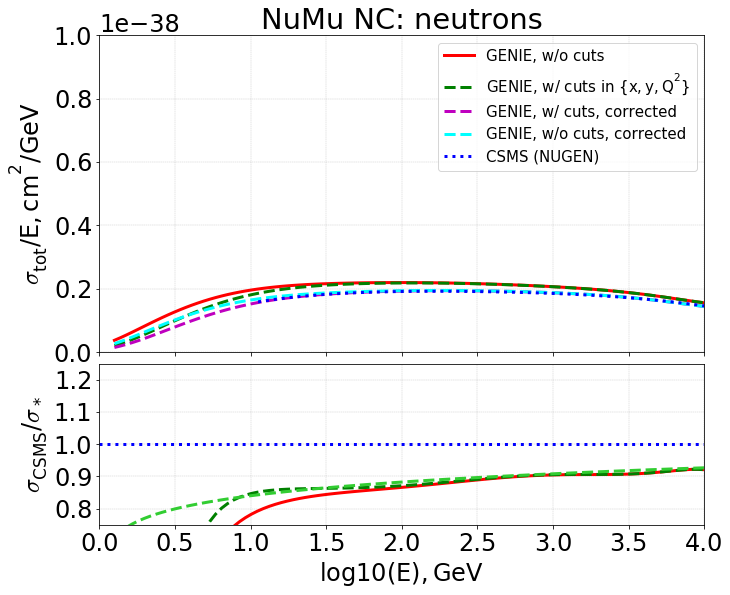

0

In [57]:
fitpar_dict = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_NC_n.npy')[0]

cut_x = fitpar_dict['x']
cut_xy = fitpar_dict['xy']
cut_xyQ2 = fitpar_dict['xyQ2']

plot_xsec_corr_numu_cc_extrap(il_genie_p=ind_NuMu_NC, 
                      il_hedis_p=ind_hedis_NuMu_NC,
                      key_csms = 'total_nu_NC_n_NLO_HERAPDF1.5NLO_EIG',
                      title = 'NuMu NC',
                      a = 0.16, p = 0.06
                      )#, y_r=[0.,.5e-38])

# NuMu Bar

In [76]:
def plot_xsec_corr_numu_bar(il_genie_p=ind_NuMu_CC,
                          il_hedis_p=ind_hedis_NuMu_CC, 
                          key_csms = 'total_nu_CC_n_NLO_HERAPDF1.5NLO_EIG',
                          title = 'NuMu CC', save_name = 'NuMu_CC',
                          y_r=[0.,1.e-38],
                          a = 0., p = 0.):
    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(10)
    ax = plt.axes(rect1)

    ax.set_xlim(1.,4.)
    ax.set_ylim(y_r)
    ax.set_title(title + ': neutrons')
#     ax.set_ylabel('total xsec/E, cm^2/GeV')
    ax.set_ylabel(r'$\mathrm{\sigma_{tot}/E, cm^2/GeV}$')
    plt.xticks(visible=False)

    comm_x = np.linspace(0.1,4.0,100)
    hedis_comm_x = np.linspace(2.,4.0,100)

    # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    ax.plot(xsec_csms[key_csms]['lgE'], 
            xsec_csms[key_csms]['xsec_per_E'],
            lw=3, linestyle=':', color='b', label = 'CSMS (NUGEN)')
    
    x = xsec_csms[key_csms]['lgE']
    y = xsec_csms[key_csms]['xsec_per_E']
    fitpar = np.polyfit(x, y, 9)
    fit_dat_csms = np.polyval(fitpar, comm_x)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    fit_arr_p = []
    fit_arr_p_4hedis = []
    for i in range(len(il_genie_p)):

        i_g2 = il_genie_p[i]
        if len(i_g2) > 0:
            x = lgE_genie[i_g2]
            y = xsec_E_genie[i_g2]#/8.
            fitpar = np.polyfit(x, y, 8)
            fit = np.polyval(fitpar, comm_x)
            fit_arr_p.append(fit)
            
            fit_4hedis = np.polyval(fitpar, hedis_comm_x)
            fit_arr_p_4hedis.append(fit_4hedis)

    fit_arr_p = np.array(fit_arr_p)
    sum_fit_p = np.sum(fit_arr_p, axis=0)
    
    fit_arr_p_4hedis = np.array(fit_arr_p_4hedis)
    sum_fit_p_4hedis = np.sum(fit_arr_p_4hedis, axis=0)
    
    ax.plot(comm_x, sum_fit_p, linestyle='-', c='red', lw=3, label=r'GENIE, w/o cuts')
    
    fit_x = np.polyval(cut_x, comm_x)
    fit_xy = np.polyval(cut_xy, comm_x)
    fit_xyQ2 = np.polyval(cut_xyQ2, comm_x)
    
#     ax.plot(comm_x, sum_fit_p*fit_x, '-', label='cut on x>x_min')
#     ax.plot(comm_x, sum_fit_p*fit_xy, '-', label='cut on x>x_min + y>y_min')
    ax.plot(comm_x, sum_fit_p*fit_xyQ2, '--', c='g', lw=3,
            label=r'GENIE, w/ cuts in {$\mathrm{x,y,Q^2}$}')
    
    corr = np.ones(len(comm_x))
    ind_corr_low = np.transpose(np.argwhere(comm_x < 1.))[0]
    corr[ind_corr_low] = (comm_x[ind_corr_low]**p) - a
    
    ind_corr_high = np.transpose(np.argwhere(comm_x > 1.))[0]
    corr[ind_corr_high] = (fit_dat_csms/(sum_fit_p*fit_xyQ2))[ind_corr_high]
    
    ax.plot(comm_x, sum_fit_p*fit_xyQ2*corr, '--', c='m', lw=3, 
        label=r'GENIE, w/ cuts, corrected')
    
    ax.plot(comm_x, sum_fit_p*corr, '--', c='cyan', lw=3, 
        label=r'GENIE, w/o cuts, corrected')

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax.axvline(1.68, lw=1, linestyle='-', color='k', label='50 GeV')
    ax.grid(color='grey', linestyle='--', linewidth=0.4, alpha=0.5)
    plt.legend(fontsize=15, ncol=1)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    ax2 = plt.axes(rect2)
    ax2.set_xlim(1.,4.)
    ax2.set_ylim(0.75, 1.25)
    ax2.set_yticks([0.8, 0.9, 1.0, 1.1, 1.2])
    ax2.set_xlabel(r'$\mathrm{log10(E), GeV}$')
    ax2.set_ylabel(r'$\mathrm{\sigma_{CSMS} / \sigma_*}$')
    
#     ax2.plot(hedis_comm_x, hedis_sum_fit_p/sum_fit_p_4hedis, c='orange', 
#              lw=3, linestyle='--')
    ax2.plot(comm_x, fit_dat_csms/sum_fit_p, linestyle='-', c='red', lw=3)
#     ax2.plot(comm_x, fit_dat_csms/(sum_fit_p*fit_x), '-', 
#              label='cut on x>x_min')
#     ax2.plot(comm_x, fit_dat_csms/(sum_fit_p*fit_xy), '-', 
#              label='cut on x>x_min + y>y_min')
    ax2.plot(comm_x, fit_dat_csms/(sum_fit_p*fit_xyQ2), '--', c='green', lw=3, 
             label='cut on x>x_min + y>y_min + Q2>Q2_min')  
    
    ax2.plot(comm_x, corr, '--', c='limegreen', lw=3, 
             label='cut on x>x_min + y>y_min + Q2>Q2_min')  
        
    print 'a = ', a, '; p = ', p
        
    ax2.axhline(1.0, lw=3, linestyle=':', color='b')
    ax2.axvline(1.68, lw=1, linestyle='-', color='k')
    ax2.grid(color='grey', linestyle='--', linewidth=0.4, alpha=0.5)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    save_name = title.replace(' ', '_')
#     plt.savefig(global_save_path+save_name+'_n'+'.png', dpi='figure')
#     plt.savefig(global_save_path+save_name+'_n'+'.pdf', dpi='figure')
    plt.show()
    
    return 0

a =  0.0 ; p =  0.0


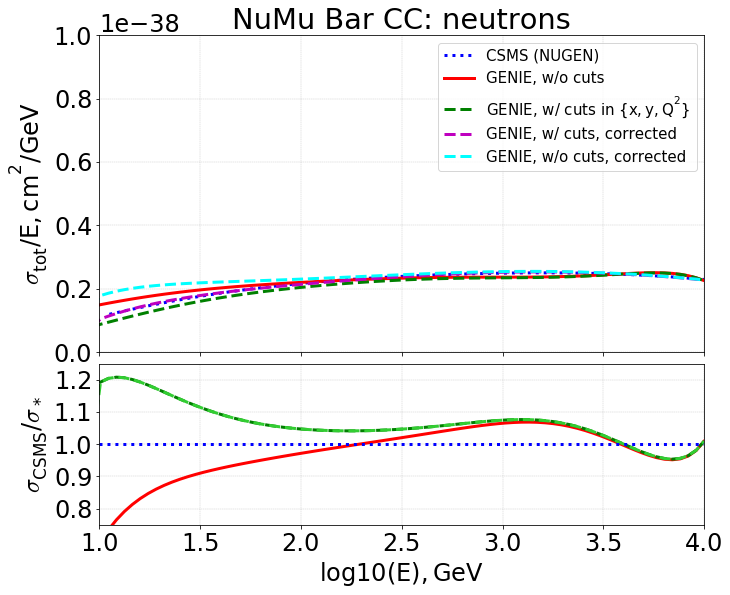

0

In [77]:
fitpar_dict = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_CC_n.npy')[0]

cut_x = fitpar_dict['x']
cut_xy = fitpar_dict['xy']
cut_xyQ2 = fitpar_dict['xyQ2']

plot_xsec_corr_numu_bar(il_genie_p=ind_NuMu_Bar_CC, 
                          il_hedis_p=ind_hedis_NuMu_Bar_CC, 
                          key_csms = 'total_nubar_CC_n_NLO_HERAPDF1.5NLO_EIG',
                          title = 'NuMu Bar CC')

a =  0.0 ; p =  0.0


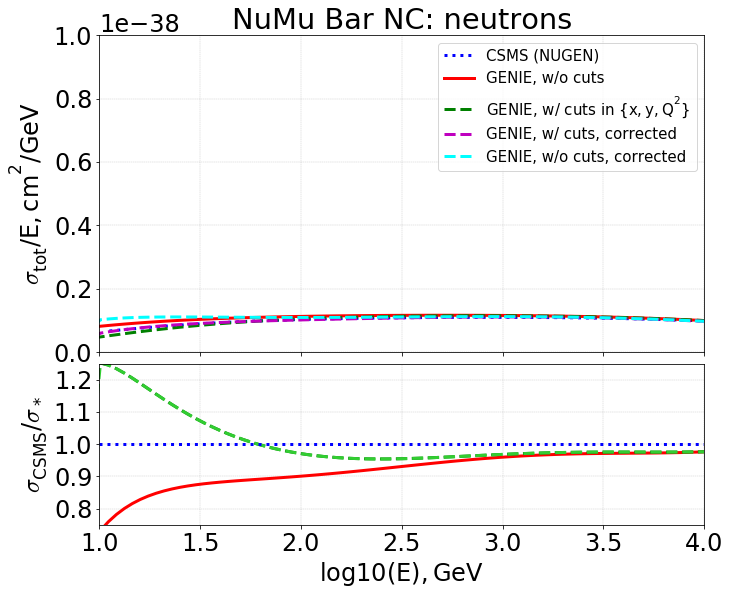

0

In [78]:
fitpar_dict = np.load(pth_cuts+
    'low_en_number_of_ev_ratios_fits_after_x_y_Q2_cuts_NuMu_Bar_NC_n.npy')[0]

plot_xsec_corr_numu_bar(il_genie_p=ind_NuMu_Bar_NC,
                          il_hedis_p=ind_hedis_NuMu_Bar_NC, 
                          key_csms = 'total_nubar_NC_n_NLO_HERAPDF1.5NLO_EIG',
                          title = 'NuMu Bar NC')#, y_r=[0.,.5e-38])

In [ ]:
# save func

In [113]:
def plot_xsec_corr_with_genie_xml(il_genie_p=ind_NuMu_CC_p, il_genie_n=ind_NuMu_CC_n,
                   il_genie_xml_p=ind_genie_NuMu_CC_p, il_genie_xml_n=ind_genie_NuMu_CC_n,
                   il_genie_ch_xml_p=ind_genie_ch_NuMu_CC_p, il_genie_ch_xml_n=ind_genie_ch_NuMu_CC_n,
                  key_csms = 'total_nu_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                  title = 'NuMu CC', save_name = 'NuMu_CC',
                  y_r=[0.,1.e-38]):
    
    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(10)
    ax = plt.axes(rect1)

    E_min = 1.68
    
    ax.set_xlim(E_min,4.)
    ax.set_ylim(y_r)
    ax.set_title(title + ': isoscalar')
#     ax.set_ylabel('total xsec/E, cm^2/GeV')
    ax.set_ylabel(r'$\mathrm{\sigma_{tot}/E, cm^2/GeV}$')
    plt.xticks(visible=False)

    comm_x = np.linspace(E_min,4.0,100)

    # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    genie_xml_fit_arr_p = []
    xs = []
    ys = []
    
    for i in range(len(il_genie_xml_p)):

        i_g2 = il_genie_xml_p[i]

        if len(i_g2) > 0:
            x = lgE_genie_xml[i_g2]
            y = xsec_E_genie_xml[i_g2]
            ind_ch_low = np.transpose(np.argwhere(x> 1.))[0]
            fitpar = np.polyfit(x[ind_ch_low], y[ind_ch_low], 5)
#             fitpar = np.polyfit(x, y, 5)
            fit = np.polyval(fitpar, comm_x)
            genie_xml_fit_arr_p.append(fit)
            
            ys.append(y)
            
#     ax.scatter(x, 
#            np.sum(ys, axis=0),
#            c='magenta', s=3.3, label='.xml n: DIS')
    genie_xml_sum_fit_p = np.sum(genie_xml_fit_arr_p, axis=0)
#     ax.plot(comm_x, genie_xml_sum_fit_p, c='lime')

    
    
    genie_ch_xml_fit_arr_p = []
    xs = []
    ys = []
    for i in range(len(il_genie_ch_xml_p)):

        i_g2 = il_genie_ch_xml_p[i]

        if len(i_g2) > 0:
            x = lgE_genie_ch_xml[i_g2]
            y = xsec_E_genie_ch_xml[i_g2]
            
            fitpar = np.polyfit(x, y, 8)
            fit = np.polyval(fitpar, comm_x)
            genie_ch_xml_fit_arr_p.append(fit)
            
            ys.append(y)
         
#     if len(ys) > 0:
#         ax.scatter(x, 
#                np.sum(ys, axis=0),
#                c='cyan', s=2.3, label='.xml n: DIS-CHARM-CC')
    genie_ch_xml_sum_fit_p = np.sum(genie_ch_xml_fit_arr_p, axis=0)
    
    genie_xml_fit_arr_n = []
    xs = []
    ys = []
    
    for i in range(len(il_genie_xml_n)):

        i_g2 = il_genie_xml_n[i]

        if len(i_g2) > 0:
        

            x = lgE_genie_xml[i_g2]
            y = xsec_E_genie_xml[i_g2]
            ind_ch_low = np.transpose(np.argwhere(x> 1.))[0]
            fitpar = np.polyfit(x[ind_ch_low], y[ind_ch_low], 8)
#             fitpar = np.polyfit(x, y, 5)
            fit = np.polyval(fitpar, comm_x)
            genie_xml_fit_arr_n.append(fit)
            
            ys.append(y)
            
#     ax.scatter(x, 
#            np.sum(ys, axis=0),
#            c='magenta', s=3.3, label='.xml n: DIS')
    genie_xml_sum_fit_n = np.sum(genie_xml_fit_arr_n, axis=0)
#     ax.plot(comm_x, genie_xml_sum_fit_n, c='lime')    
#     ax.plot(comm_x, (genie_xml_sum_fit_n+genie_xml_sum_fit_p)/2., c='magenta', label='genie xml DIS')

    
    
    genie_ch_xml_fit_arr_n = []
    xs = []
    ys = []
    for i in range(len(il_genie_ch_xml_n)):

        i_g2 = il_genie_ch_xml_n[i]

        if len(i_g2) > 0:
            x = lgE_genie_ch_xml[i_g2]
            y = xsec_E_genie_ch_xml[i_g2]
            
            fitpar = np.polyfit(x, y, 8)
            fit = np.polyval(fitpar, comm_x)
            genie_ch_xml_fit_arr_n.append(fit)
            
            ys.append(y)
         
#     if len(ys) > 0:
#         ax.scatter(x, 
#                np.sum(ys, axis=0),
#                c='cyan', s=2.3, label='.xml n: DIS-CHARM-CC')
    genie_ch_xml_sum_fit_n = np.sum(genie_ch_xml_fit_arr_n, axis=0)
    
    
#     ax.plot(comm_x, (genie_ch_xml_sum_fit_n+genie_xml_sum_fit_p)/2., c='cyan', label='genie xml DIS-CHARM')
    ax.plot(comm_x, 
            (genie_ch_xml_sum_fit_p+genie_xml_sum_fit_p+genie_ch_xml_sum_fit_n+genie_xml_sum_fit_n)/2., 'o',
            label='genie xml SUM')
    
    # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    
    ax.plot(xsec_csms[key_csms]['lgE'], 
            xsec_csms[key_csms]['xsec_per_E'],
            lw=3, linestyle=':', color='b', label = 'CSMS (NUGEN)')
    
#     print xsec_csms[key_csms]['lgE'][:15], xsec_csms[key_csms]['xsec_per_E'][:15]
    
    x = xsec_csms[key_csms]['lgE']
    y = xsec_csms[key_csms]['xsec_per_E']
    fitpar = np.polyfit(x, y, 9)
    fit_dat_csms = np.polyval(fitpar, comm_x)
    
#     ax.plot(xsec_csms_p[key_csms.replace('iso', 'p')]['lgE'], 
#             xsec_csms_p[key_csms.replace('iso', 'p')]['xsec_per_E'],
#             lw=3, linestyle=':', color='c', label = 'CSMS p (NUGEN)')
    
#     x = xsec_csms_p[key_csms.replace('iso', 'p')]['lgE']
#     y = xsec_csms_p[key_csms.replace('iso', 'p')]['xsec_per_E']
#     fitpar = np.polyfit(x, y, 9)
#     fit_dat_csms_p = np.polyval(fitpar, comm_x)

#     ax.plot(xsec_csms_n[key_csms.replace('iso', 'n')]['lgE'], 
#             xsec_csms_n[key_csms.replace('iso', 'n')]['xsec_per_E'],
#             lw=3, linestyle=':', color='c', label = 'CSMS n (NUGEN)')
    
#     x = xsec_csms_n[key_csms.replace('iso', 'n')]['lgE']
#     y = xsec_csms_n[key_csms.replace('iso', 'n')]['xsec_per_E']
#     fitpar = np.polyfit(x, y, 9)
#     fit_dat_csms_n = np.polyval(fitpar, comm_x)
    
#     ax.plot(comm_x, (fit_dat_csms_p+fit_dat_csms_n)/2., ':', lw=3, c='violet', 
# label='calc. iso CSMS (NUGEN)')
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    fit_arr_p = []
    for i in range(len(il_genie_p)):

        i_g2 = il_genie_p[i]
        if len(i_g2) > 0:
            x = lgE_genie_p[i_g2]
            y = xsec_E_genie_p[i_g2]#/8.
            fitpar = np.polyfit(x, y, 8)
            fit = np.polyval(fitpar, comm_x)
            fit_arr_p.append(fit)
            
    fit_arr_p = np.array(fit_arr_p)
    sum_fit_p = np.sum(fit_arr_p, axis=0)
    
    fit_arr_n = []
    for i in range(len(il_genie_n)):

        i_g2 = il_genie_n[i]
        if len(i_g2) > 0:
            x = lgE_genie_n[i_g2]
            y = xsec_E_genie_n[i_g2]#/8.
            fitpar = np.polyfit(x, y, 8)
            fit = np.polyval(fitpar, comm_x)
            fit_arr_n.append(fit)

    fit_arr_n = np.array(fit_arr_n)
    sum_fit_n = np.sum(fit_arr_n, axis=0)
    
    sum_fit_iso = (sum_fit_p+sum_fit_n)/2.
    
#     print max(sum_fit_iso)
    
    ax.plot(comm_x, sum_fit_iso, linestyle='-', c='red', lw=3, label=r'GENIE, w/o cuts')
    
    fit_xyQ2_p = np.polyval(cut_xyQ2_p, comm_x)
    fit_xyQ2_n = np.polyval(cut_xyQ2_n, comm_x)
    
    sum_fit_iso_cuts = (sum_fit_p*fit_xyQ2_p+sum_fit_n*fit_xyQ2_n)/2.
    
#     ax.plot(comm_x, sum_fit_iso_cuts, '--', c='g', lw=3, 
#             label=r'GENIE, w/ cuts in {$\mathrm{x,y,Q^2}$}')
    
    f = np.polyfit(comm_x, fit_dat_csms/sum_fit_iso_cuts, 7)
    f_v = np.polyval(f, comm_x)
    
#     ax.plot(comm_x, sum_fit_iso*f_v, linestyle='-', c='cyan', lw=3, label=r'GENIE, w/o cuts, corrected')
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    
    if title == 'NuMu Bar CC':
#         ax.plot(gaz_lgE, gaz_xsec*1e-38, '-', c='k', lw=2.5, 
#                 label=r'Gazizov DIS xsec')
#         ax.plot(gaz_lgE_unc_bot, gaz_xsec_unc_bot*1e-38, '-', c='grey', lw=2, 
#                 label=r'Gazizov DIS xsec uncert.')
#         ax.plot(gaz_lgE_unc_top, gaz_xsec_unc_top*1e-38, '-', c='grey', lw=2, 
#                 )
#         ax.plot(gaz_sum_lgE, gaz_sum_xsec*1e-38, '.', c='k', lw=2.5, 
#                 label=r'Gazizov DIS+RES+QES xsec')
#         ax.plot(gaz_genie_lgE, gaz_genie_xsec*1e-38, '.-', c='maroon', lw=1, 
#                 label=r'Gazizov GENIE')

        ax.plot(ev_lgE_numu_bar, ev_xsec_numu_bar*1e-38, '-', c='k', lw=2.5, 
                label=r'eV2EeV DIS xsec')
        ax.plot(ev_sum_lgE_numu_bar, ev_sum_xsec_numu_bar*1e-38, '-', c='k', lw=2.5, 
                label=r'eV2EeV total xsec')
        ax.plot(np.log10(d_csms_paper['E']), 
                d_csms_paper['sig_nubar_cc']/d_csms_paper['E']*1e-38, 
                'o-', c='gold', lw=2, 
                label='CSMS paper')
        
        
    if title == 'NuMu CC':
#         ax.plot(gaz_lgE_numu, gaz_xsec_numu*1e-38, '-', c='k', lw=2.5, 
#                 label=r'Gazizov DIS xsec')
#         ax.plot(gaz_lgE_unc_bot_numu, gaz_xsec_unc_bot_numu*1e-38, '-', c='grey', lw=2, 
#                 label=r'Gazizov DIS xsec uncert.')
#         ax.plot(gaz_lgE_unc_top_numu, gaz_xsec_unc_top_numu*1e-38, '-', c='grey', lw=2, 
#                 )
#         ax.plot(gaz_sum_lgE_numu, gaz_sum_xsec_numu*1e-38, '.', c='k', lw=2.5, 
#                 label=r'Gazizov DIS+RES+QES xsec')
#         ax.plot(gaz_data_lgE_numu, gaz_data_xsec_numu*1e-38, 'o', markersize=5, c='m', lw=2.5, 
#                 label=r'Gazizov data points')

        ax.plot(ev_lgE_numu, ev_xsec_numu*1e-38, '-', c='k', lw=2.5, 
                label=r'eV2EeV DIS xsec')
        ax.plot(ev_sum_lgE_numu, ev_sum_xsec_numu*1e-38, '-', c='k', lw=2.5, 
                label=r'eV2EeV total xsec')
        ax.plot(np.log10(d_csms_paper['E']), 
                d_csms_paper['sig_nu_cc']/d_csms_paper['E']*1e-38, 
                'o-', c='gold', lw=2, 
                label='CSMS paper')
        
    if title == 'NuMu NC':
        ax.plot(np.log10(d_csms_paper['E']), 
                d_csms_paper['sig_nu_nc']/d_csms_paper['E']*1e-38, 
                'o-', c='gold', lw=2, 
                label='CSMS paper')
        
    if title == 'NuMu Bar NC':
        ax.plot(np.log10(d_csms_paper['E']), 
                d_csms_paper['sig_nubar_nc']/d_csms_paper['E']*1e-38, 
                'o-', c='gold', lw=2, 
                label='CSMS paper')
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#     ax.axvline(1.68, lw=1, linestyle='-', color='k', label='50 GeV')
    ax.grid(color='grey', linestyle='--', linewidth=0.4, alpha=0.5)
    plt.legend(fontsize=15, ncol=2)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    ax2 = plt.axes(rect2)
    ax2.set_xlim(E_min,4.)
    ax2.set_ylim(0.75, 1.25)
    ax2.set_yticks([0.8, 0.9, 1.0, 1.1, 1.2])
    ax2.set_xlabel(r'$\mathrm{log10(E), GeV}$')
    ax2.set_ylabel(r'$\mathrm{\sigma_{CSMS} / \sigma_*}$')
    
    ax2.plot(comm_x, fit_dat_csms/sum_fit_iso, linestyle='-', c='red', lw=3)
    ax2.plot(comm_x, fit_dat_csms/sum_fit_iso_cuts, '--', c='green', lw=3, 
             label='cut on x>x_min + y>y_min + Q2>Q2_min')    
        
#     comm_x_20 = np.linspace(1.,4.0,1000)



#     ax2.plot(comm_x_20,  f_v, '.', c='yellow') 
#     ax2.axvline(1.68, lw=1, linestyle='-', color='k')
    ax2.axhline(1.0, lw=3, linestyle=':', color='b')
    ax2.grid(color='grey', linestyle='--', linewidth=0.4, alpha=0.5)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    
    if title == 'NuMu Bar CC':
        save_name = title.replace(' ', '_')
        save_path_latex = '/home/maria/IceCube/crosssections/fig_latex/total_xsec/low_en/'
        plt.savefig(save_path_latex+save_name+'_iso_low_en_comp_gazizov'+'.png', dpi='figure')
        plt.savefig(save_path_latex+save_name+'_iso_low_en_comp_gazizov'+'.pdf', dpi='figure')
        
    if title == 'NuMu CC':
        save_name = title.replace(' ', '_')
        save_path_latex = '/home/maria/IceCube/crosssections/fig_latex/total_xsec/low_en/'
        plt.savefig(save_path_latex+save_name+'_iso_low_en_comp_gazizov'+'.png', dpi='figure')
        plt.savefig(save_path_latex+save_name+'_iso_low_en_comp_gazizov'+'.pdf', dpi='figure')
#     save_name = title.replace(' ', '_')
#     plt.savefig(global_save_path+save_name+'_n'+'.png', dpi='figure')
#     plt.savefig(global_save_path+save_name+'_n'+'.pdf', dpi='figure')
    plt.show()
    
    return f